In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import sys
import os
from pathlib import Path

current_dir = Path.cwd()
if current_dir.name == "notebooks":
    project_root = current_dir.parent
    os.chdir(project_root)
    print(f"Cambiado directorio de trabajo a: {project_root}")
else:
    project_root = current_dir
    print(f"Directorio de trabajo: {project_root}")

sys.path.insert(0, str(project_root / "neural_net"))

from utils.visualization import *

(project_root / "figures").mkdir(exist_ok=True)
plt.style.use("figs.mplstyle")
plt.rcParams["figure.dpi"] = 300
print(f"GPU disponible: {cp.cuda.runtime.getDeviceCount()}")
print(f"GPU en uso: {cp.cuda.Device()}")

Cambiado directorio de trabajo a: /home/santiago/Universidad/Tercer Año/machineLearning/tps/tp3
GPU disponible: 1
GPU en uso: <CUDA Device 0>


<div style="font-family: Georgia, serif; font-size: 20px; line-height: 1.5;">

<style>
h1 { color: #8db2d7ff; font-weight: 700; }
h2 { color: #4a90e2; font-weight: 500; }
h3 { color: #6b8ea3; font-weight: 400; }
</style>

## 1. Exploración y Preprocesamiento de Datos

En esta sección exploramos el dataset EMNIST Bymerge que contiene:
- **809,555 imágenes** en total
- **47 clases** (dígitos 0-9, letras A-Z y a-z con algunas exclusiones)
- **Dimensiones:** 28x28 píxeles en escala de grises

In [2]:
X_images = np.load(project_root / "data" / "X_images.npy")
y_images = np.load(project_root / "data" / "y_images.npy")

print(f"Shape de X: {X_images.shape}")
print(f"Shape de y: {y_images.shape}")
print(f"Número de clases únicas: {len(np.unique(y_images))}")
print(f"Rango de valores en X: [{X_images.min()}, {X_images.max()}]")
print(f"Tipo de dato: {X_images.dtype}")

Shape de X: (809555, 28, 28)
Shape de y: (809555,)
Número de clases únicas: 47
Rango de valores en X: [0, 255]
Tipo de dato: uint8


### 1.1 Visualización de una imagen por clase

<div style="font-family: Georgia, serif; font-size: 20px; line-height: 1.5;">

<style>
h1 { color: #8db2d7ff; font-weight: 700; }
h2 { color: #4a90e2; font-weight: 500; }
h3 { color: #6b8ea3; font-weight: 400; }
</style>


### 1.1 Visualización de una imagen por clase

Para entender la complejidad del problema, visualizamos una muestra de cada una de las 47 clases.
Esto nos permite observar la variabilidad y similitud entre diferentes caracteres.

/home/santiago/Universidad/Tercer Año/machineLearning/tps/tp3/neural_net/utils/visualization.py:182: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Figure saved to: /home/santiago/Universidad/Tercer Año/machineLearning/tps/tp3/figures/one_per_class.png


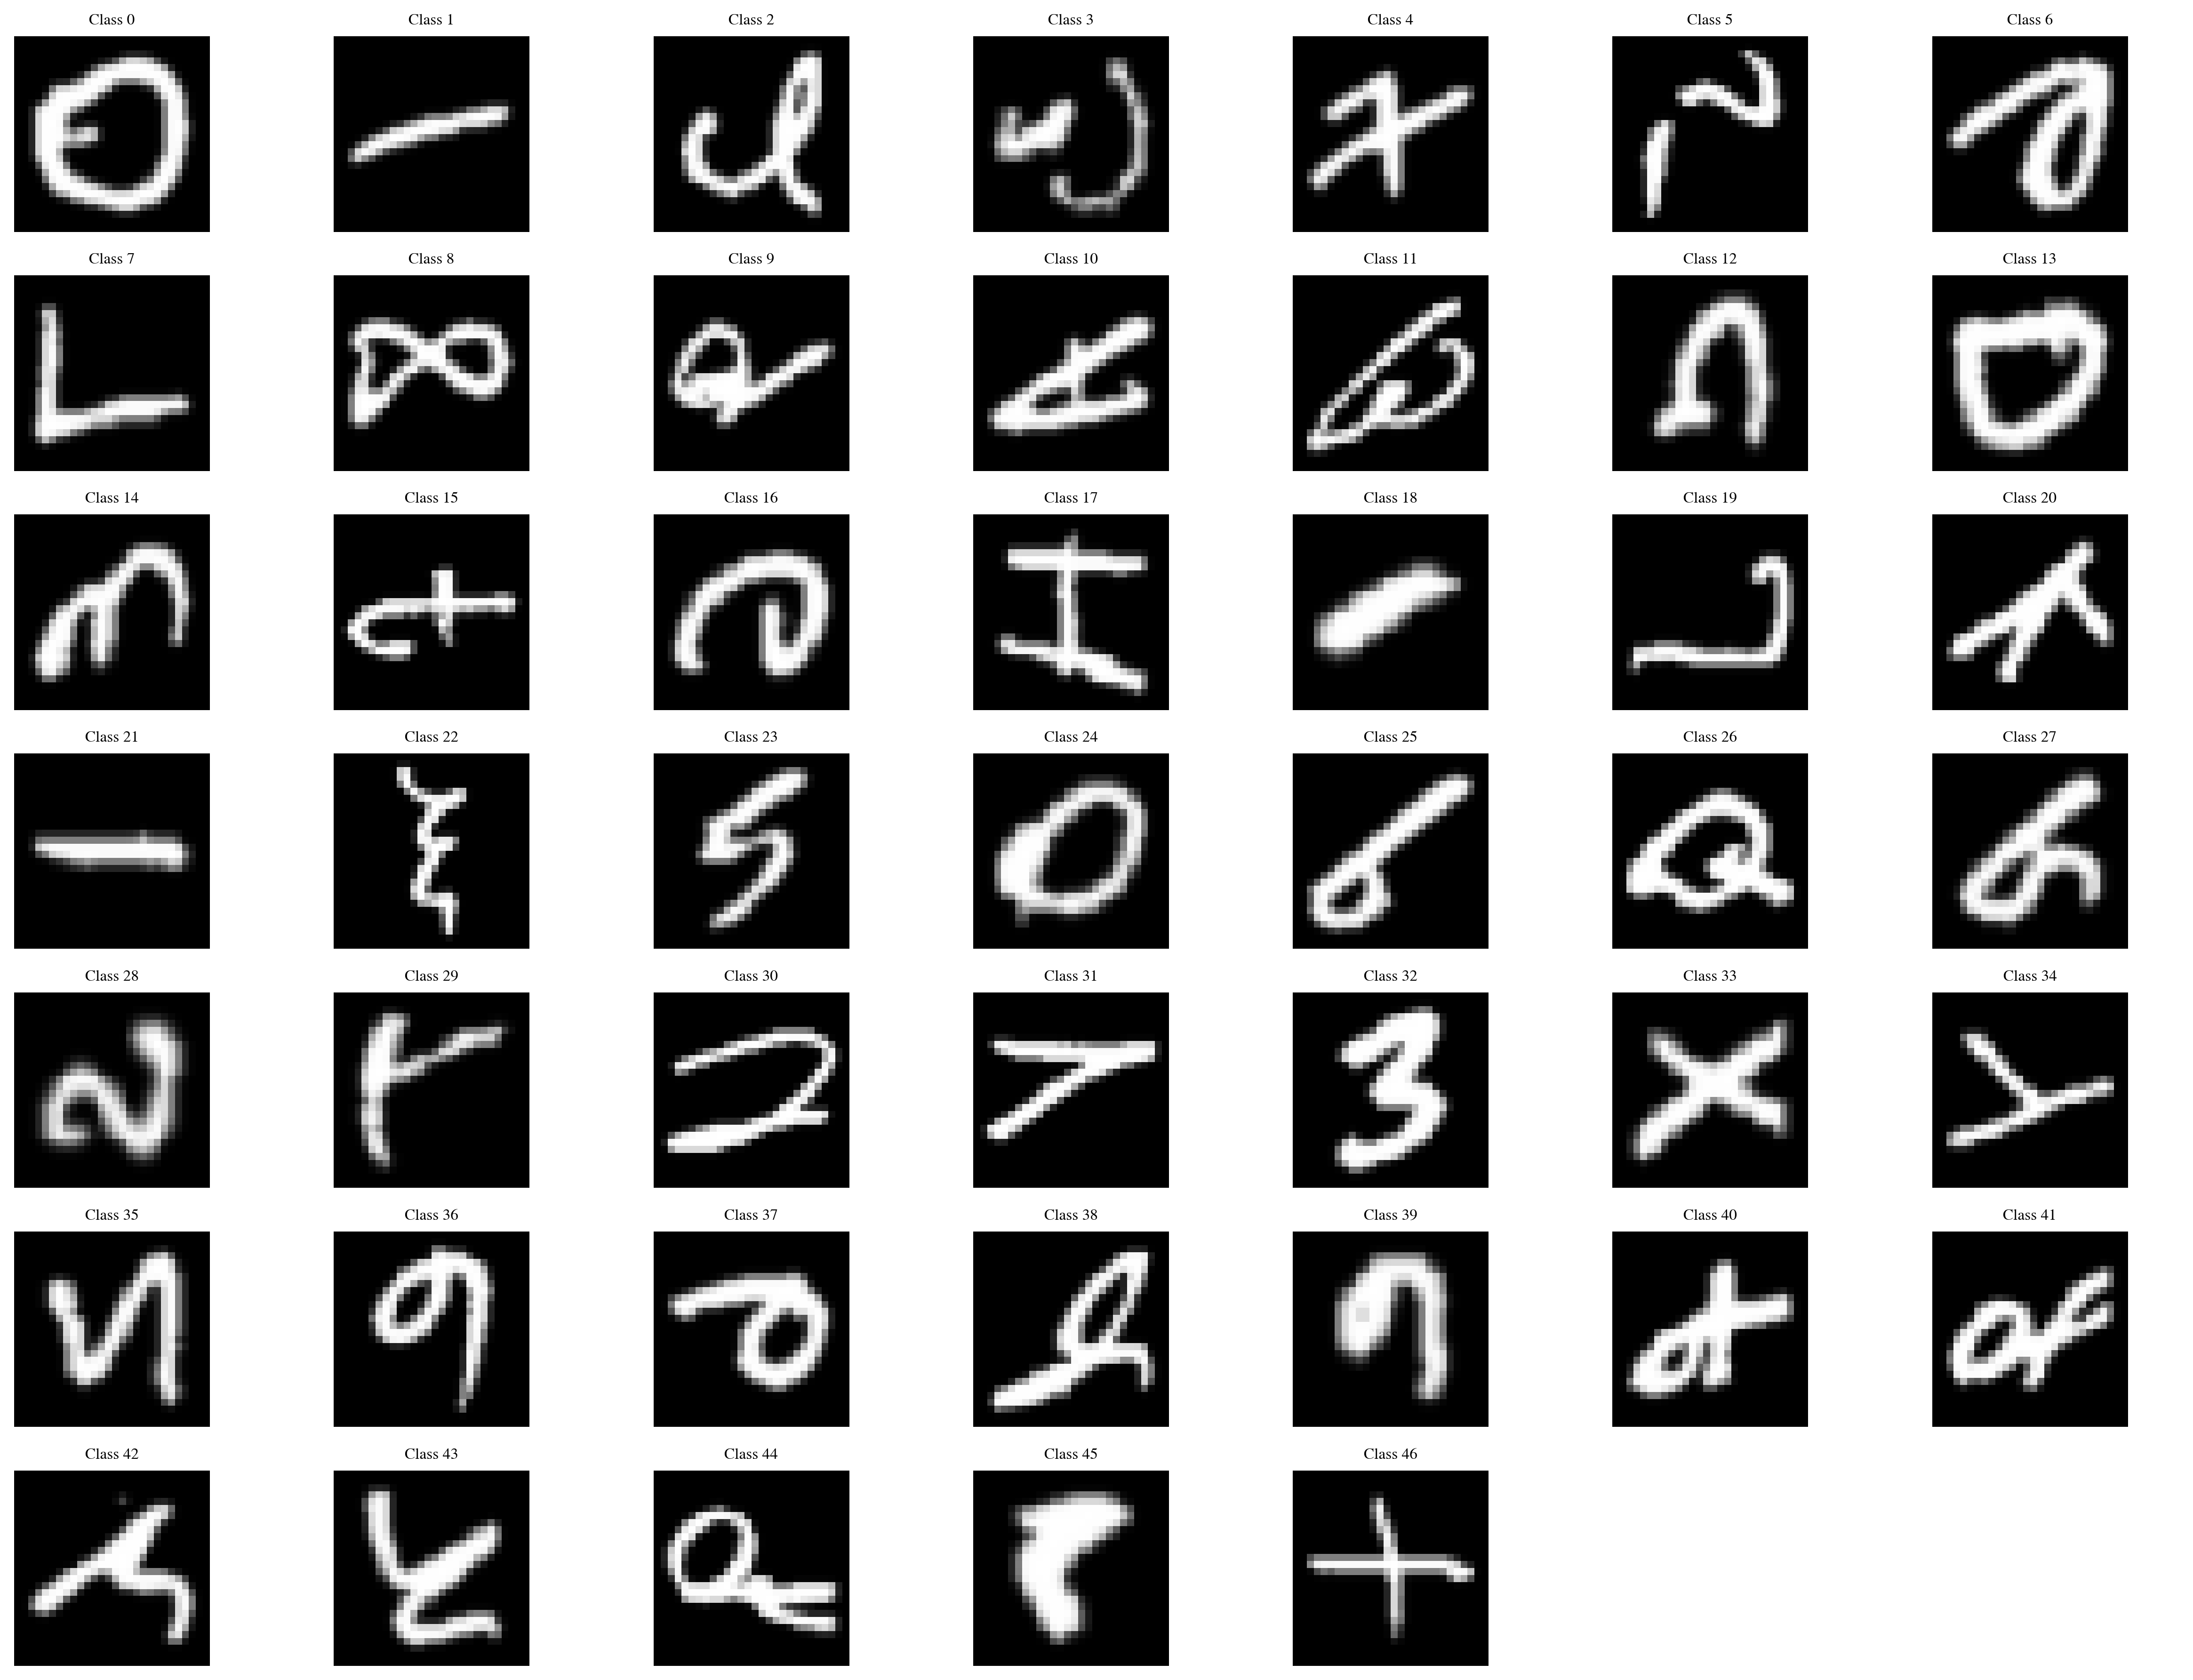

In [3]:
plot_one_per_class(
    X_images,
    y_images,
    save_path=project_root / "figures" / "one_per_class.png",
    figsize=(16, 12),
);

### 1.2 Distribución de clases

Analizamos la distribución de muestras por clase para identificar posibles desbalances
en el dataset que podrían afectar el entrenamiento de los modelos.

/home/santiago/Universidad/Tercer Año/machineLearning/tps/tp3/neural_net/utils/visualization.py:243: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Figure saved to: /home/santiago/Universidad/Tercer Año/machineLearning/tps/tp3/figures/class_distribution.png


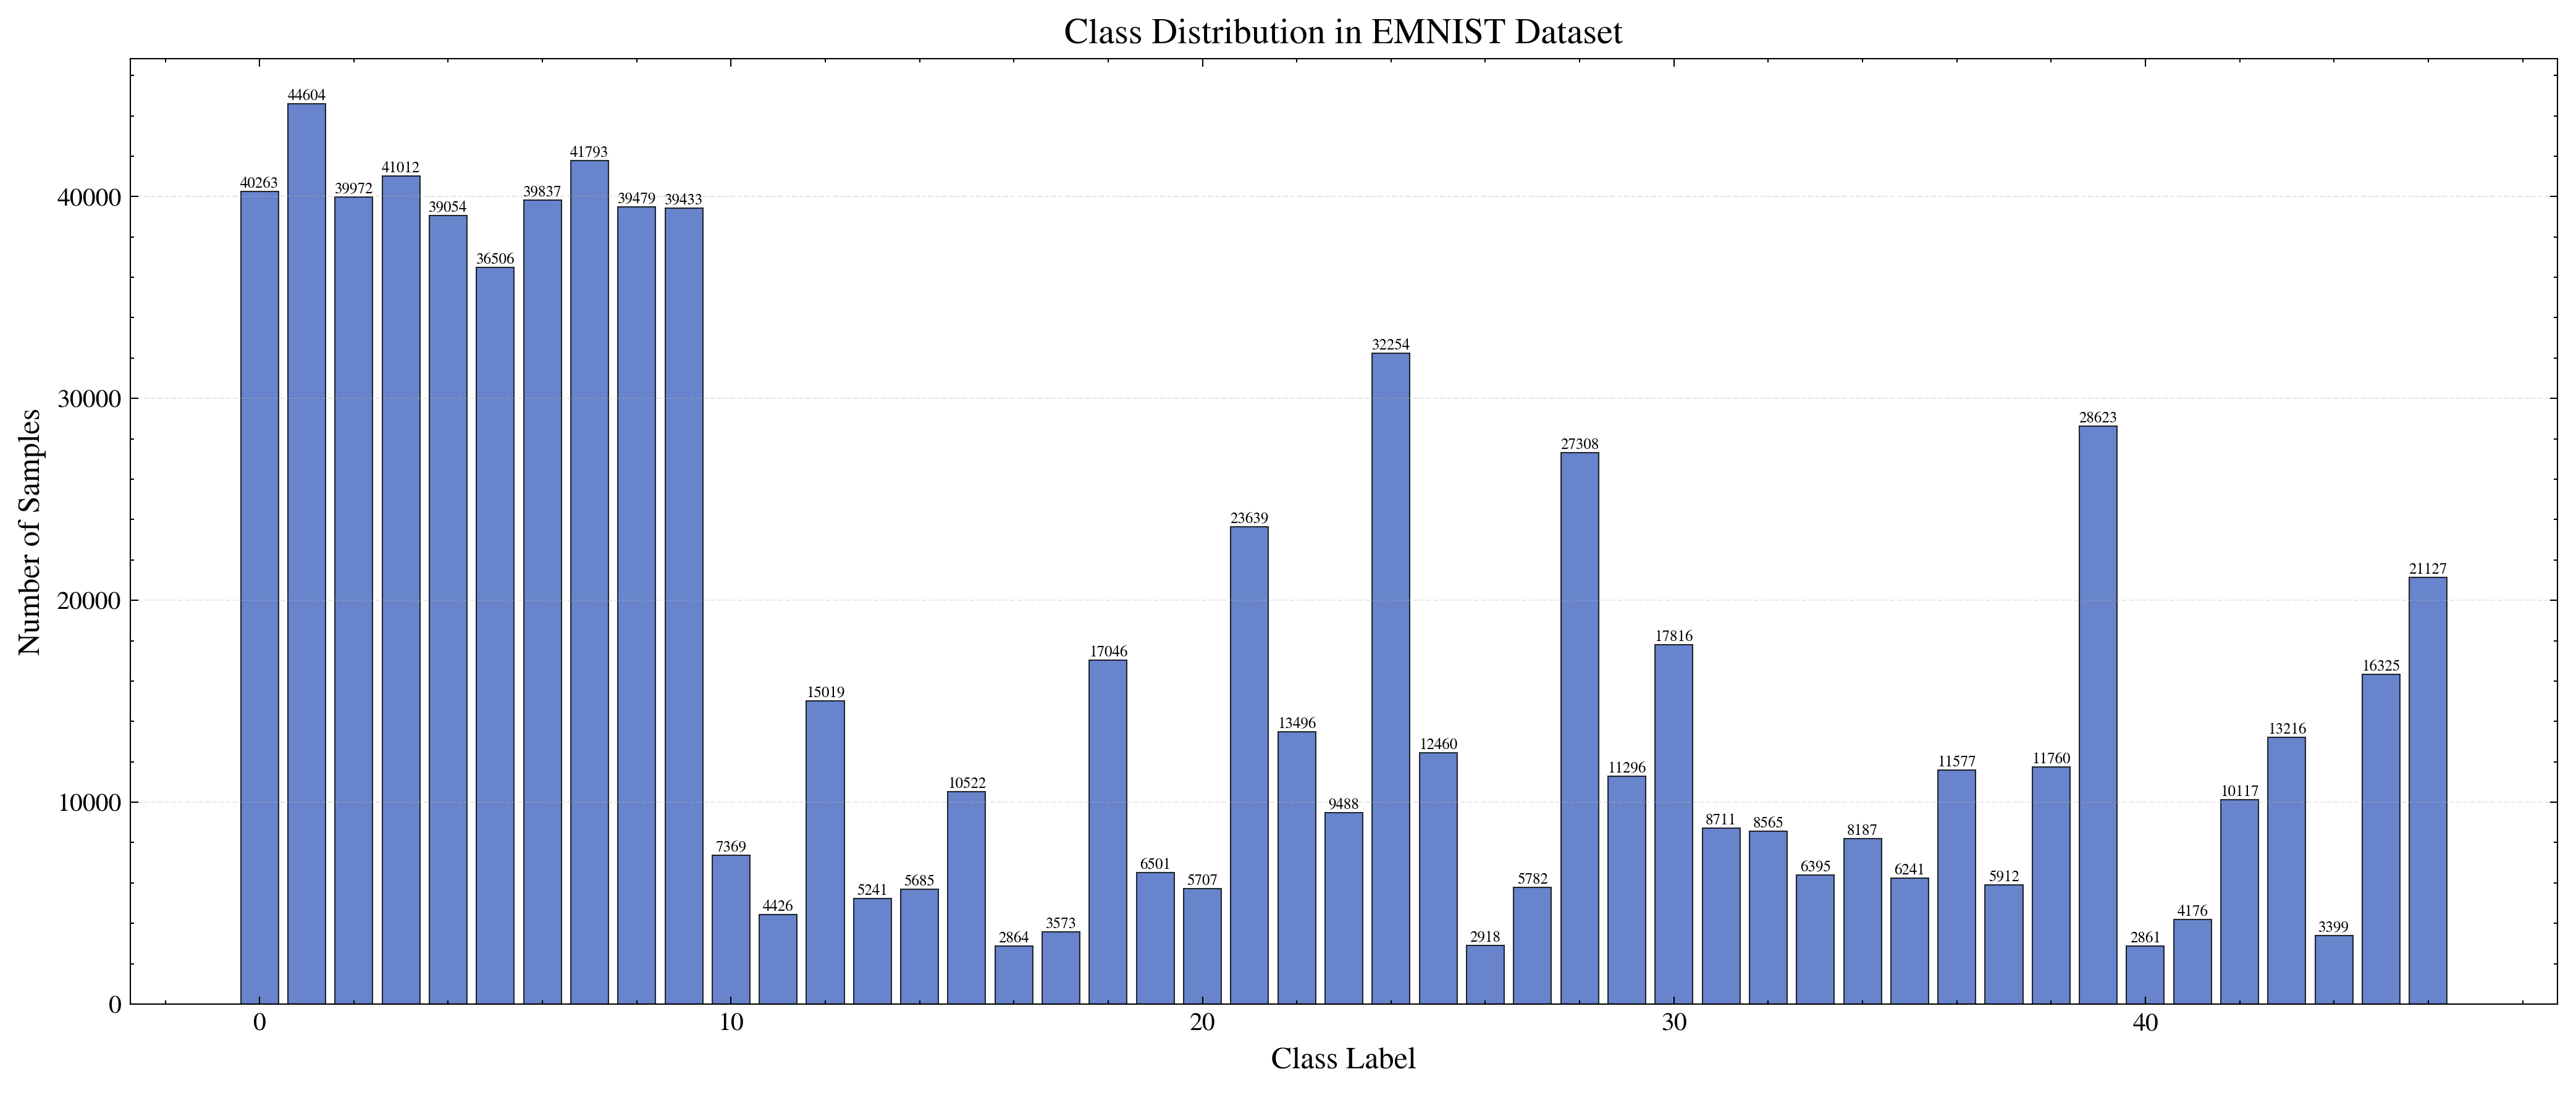


Estadísticas de distribución:
  - Media de muestras por clase: 17225
  - Std de muestras por clase: 13696
  - Clase con más muestras: 1 (44604 muestras)
  - Clase con menos muestras: 40 (2861 muestras)
  - Ratio max/min: 15.59


In [4]:
plot_class_distribution(
    y_images,
    save_path=project_root / "figures" / "class_distribution.png",
    figsize=(14, 6),
);

unique_classes, counts = np.unique(y_images, return_counts=True)
print("\nEstadísticas de distribución:")
print(f"  - Media de muestras por clase: {counts.mean():.0f}")
print(f"  - Std de muestras por clase: {counts.std():.0f}")
print(
    f"  - Clase con más muestras: {unique_classes[counts.argmax()]} ({counts.max()} muestras)"
)
print(
    f"  - Clase con menos muestras: {unique_classes[counts.argmin()]} ({counts.min()} muestras)"
)
print(f"  - Ratio max/min: {counts.max() / counts.min():.2f}")

<div style="font-family: Georgia, serif; font-size: 20px; line-height: 1.5;">

<style>
h1 { color: #8db2d7ff; font-weight: 700; }
h2 { color: #4a90e2; font-weight: 500; }
h3 { color: #6b8ea3; font-weight: 400; }
</style>

### Preprocesamiento de datos

- Normalización: convertimos los píxeles a valores entre 0 y 1 dividiendo por 255. Esto ayuda a que el entrenamiento sea más estable.

- Reestructuración: aplanamos cada imagen de 28×28 a un vector de 784 valores (así el MLP recibe entradas 1D).

- Partición de datos: se divide el dataset en 70% entrenamiento, 15% validación (desarrollo) y 15% test.

- El conjunto de desarrollo (el 15%) es el que usamos para ajustar hiperparámetros y validar modelos antes del test final

<div style="font-family: Georgia, serif; font-size: 20px; line-height: 1.5;">


<div style="font-family: Georgia, serif; font-size: 20px; line-height: 1.5;">

<style>
h1 { color: #8db2d7ff; font-weight: 700; }
h2 { color: #4a90e2; font-weight: 500; }
h3 { color: #6b8ea3; font-weight: 400; }
</style>

### 1.3 Preprocesamiento y Marco de Evaluación

- Normalización: Valores de píxeles divididos por 255 → [0, 1]
- Flatten: Imágenes (28, 28) → (784,) para el MLP

Debido al **desbalance de clases (ratio ~15:1)**, usamos **split estratificado**:

- Sin estratificación: clases minoritarias podrían tener muy pocas muestras en test
- Con estratificación: cada clase mantiene la **misma proporción** en train y test

- Train/Dev: 80% (~648k muestras, ~13,778 por clase)
- Test: 20% (~162k muestras, ~3,447 por clase)

Para hacer que las comparaciones entre modelos sean justas, mantenemos constantes los siguientes aspectos:

1. Mismo dataset (splits fijos con `random_seed=42`)
2. Mismo preprocesamiento (normalización consistente)
3. Mismas métricas (accuracy, F1-macro, confusion matrix)
4. Reproducibilidad (seeds fijos en todos los experimentos)


In [5]:
from neural_net.data.dataset import Dataset

dataset = Dataset(
    X_path=project_root / "data" / "X_images.npy",
    y_path=project_root / "data" / "y_images.npy",
    train_ratio=0.7,
    val_ratio=0.1,
    test_ratio=0.2,
    normalize=True,
    stratify=True,
    random_seed=42,
)

X_train, y_train = dataset.get_train()
X_val, y_val = dataset.get_val()
X_test, y_test = dataset.get_test()

print(f"\n{'='*60}")
print(f"Conjunto de entrenamiento: {X_train.shape[0]:,} muestras")
print(f"Conjunto de validación:    {X_val.shape[0]:,} muestras")
print(f"Conjunto de test:          {X_test.shape[0]:,} muestras")
print(f"Rango de valores: [{float(X_train.min()):.2f}, {float(X_train.max()):.2f}]")

train_dist = cp.unique(y_train, return_counts=True)
val_dist = cp.unique(y_val, return_counts=True)
test_dist = cp.unique(y_test, return_counts=True)

print(f"\n✓ Verificación de estratificación (por conjunto):")
print(
    f"  Train - Muestras por clase: min={int(train_dist[1].min()):,}, max={int(train_dist[1].max()):,}"
)
print(
    f"  Val   - Muestras por clase: min={int(val_dist[1].min()):,}, max={int(val_dist[1].max()):,}"
)
print(
    f"  Test  - Muestras por clase: min={int(test_dist[1].min()):,}, max={int(test_dist[1].max()):,}"
)

print(f"\n✓ Verificación de proporciones:")
print(f"  Train/Val ratio: {len(y_train)/len(y_val):.2f}:1 (esperado: {0.7/0.1:.2f}:1)")
print(
    f"  Train/Test ratio: {len(y_train)/len(y_test):.2f}:1 (esperado: {0.7/0.2:.2f}:1)"
)
print(f"  Val/Test ratio: {len(y_val)/len(y_test):.2f}:1 (esperado: {0.1/0.2:.2f}:1)")

print(f"\n✓ Verificación de distribución de clases (5 primeras clases como ejemplo):")
print(f"  {'Clase':<8} {'Train %':<10} {'Val %':<10} {'Test %':<10}")
print(f"  {'-'*8} {'-'*10} {'-'*10} {'-'*10}")
for i in range(min(5, len(train_dist[0]))):
    cls = int(train_dist[0][i])
    train_pct = (train_dist[1][i] / len(y_train)) * 100
    val_pct = (val_dist[1][i] / len(y_val)) * 100
    test_pct = (test_dist[1][i] / len(y_test)) * 100
    print(f"  {cls:<8} {train_pct:<10.2f} {val_pct:<10.2f} {test_pct:<10.2f}")

print(f"{'='*60}")

Loading dataset in CPU (NumPy) to save GPU memory...
Splitting dataset: 809555 samples - train: 0.70, val: 0.10, test: 0.20
Keeping data in CPU (NumPy) - batches will be moved to GPU during training
Dataset loaded:
  Train: 566667 samples
  Val:   80933 samples
  Test:  161955 samples

Conjunto de entrenamiento: 566,667 muestras
Conjunto de validación:    80,933 muestras
Conjunto de test:          161,955 muestras
Rango de valores: [0.00, 1.00]

✓ Verificación de estratificación (por conjunto):
  Train - Muestras por clase: min=2,002, max=31,222
  Val   - Muestras por clase: min=286, max=4,460
  Test  - Muestras por clase: min=573, max=8,922

✓ Verificación de proporciones:
  Train/Val ratio: 7.00:1 (esperado: 7.00:1)
  Train/Test ratio: 3.50:1 (esperado: 3.50:1)
  Val/Test ratio: 0.50:1 (esperado: 0.50:1)

✓ Verificación de distribución de clases (5 primeras clases como ejemplo):
  Clase    Train %    Val %      Test %    
  -------- ---------- ---------- ----------
  0        4.97   

<div style="font-family: Georgia, serif; font-size: 20px; line-height: 1.5;">

<style>
h1 { color: #8db2d7ff; font-weight: 700; }
h2 { color: #4a90e2; font-weight: 500; }
h3 { color: #6b8ea3; font-weight: 400; }
</style>

## 2. Experimentos

En esta sección ejecutamos y comparamos los modelos M0 (baseline) y M1 (optimizado).
Todos los modelos se evalúan bajo el **marco unificado** descrito anteriormente.

<div style="font-family: Georgia, serif; font-size: 20px; line-height: 1.5;">

<style>
h1 { color: #8db2d7ff; font-weight: 700; }
h2 { color: #4a90e2; font-weight: 500; }
h3 { color: #6b8ea3; font-weight: 400; }
</style>

### 2.1 Modelo M0: Baseline

**Configuración:**
- **Arquitectura:** [784, 128, 64, 47] (2 capas ocultas)
- **Activación:** ReLU
- **Optimizador:** SGD con learning rate = 0.001, sin momentum
- **Batch size:** 256
- **Épocas:** 50
- **Regularización:** Ninguna
- **Loss:** Cross-Entropy

Este modelo establece el **baseline** contra el cual compararemos M1.

In [6]:
from experiments.configs.configurations import M0_CONFIG
from experiments.runner import Experiment

print("=" * 70)
print("MODELO M0 - BASELINE")
print("=" * 70)
print(f"Nombre: {M0_CONFIG.name}")
print(f"Descripción: {M0_CONFIG.description}")
print(f"\nArquitectura:")
print(f"  Hidden layers: {M0_CONFIG.model.hidden_layers}")
print(f"  Activación: ReLU")
print(f"  Dropout: {M0_CONFIG.model.dropout_rate}")
print(f"\nOptimizador:")
print(f"  Tipo: {M0_CONFIG.training.optimizer.type.value}")
print(f"  Learning rate: {M0_CONFIG.training.optimizer.learning_rate}")
print(f"  Momentum: {M0_CONFIG.training.optimizer.momentum}")
print(f"\nHiperparámetros:")
print(f"  Batch size: {M0_CONFIG.training.batch_size}")
print(f"  Épocas: {M0_CONFIG.training.epochs}")
print(f"  L2 regularization: {M0_CONFIG.training.regularizer.use_l2}")
print(f"  Early stopping: {M0_CONFIG.training.early_stopping.enabled}")
print("=" * 70)

MODELO M0 - BASELINE
Nombre: M0
Descripción: Baseline: 2 hidden layers [128, 64], SGD, no regularization

Arquitectura:
  Hidden layers: [128, 64]
  Activación: ReLU
  Dropout: None

Optimizador:
  Tipo: <class 'neural_net.optimizers.sgd.SGD'>
  Learning rate: 0.001
  Momentum: 0.0

Hiperparámetros:
  Batch size: 512
  Épocas: 100
  L2 regularization: False
  Early stopping: False


In [7]:
import time

experiment_m0 = Experiment(M0_CONFIG, dataset)
experiment_m0.build()
print("Experimento M0 construido\n")

cp.get_default_memory_pool().free_all_blocks()
print("Memoria GPU liberada\n")

print("Entrenando M0...")

# Entrenar modelo (el trainer ya usa X_train, X_val, X_test del dataset)
# NOTA: Dataset ahora mantiene datos en CPU y solo mueve batches a GPU
start_time = time.time()
history_m0 = experiment_m0.trainer.train(
    X_train,
    y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=M0_CONFIG.training.epochs,
    batch_size=M0_CONFIG.training.batch_size,
)
train_time_m0 = time.time() - start_time

print("\nEntrenamiento M0 completado")
print(f"Tiempo total: {train_time_m0:.2f} segundos ({train_time_m0/60:.2f} minutos)")
print(f"Loss final (train): {history_m0['train_loss'][-1]:.4f}")
if "train_metric" in history_m0:
    print(f"Accuracy final (train): {history_m0['train_metric'][-1]:.4f}")
if "val_loss" in history_m0:
    print(f"Loss final (val): {history_m0['val_loss'][-1]:.4f}")
if "val_metric" in history_m0:
    print(f"Accuracy final (val): {history_m0['val_metric'][-1]:.4f}")

Experimento M0 construido

Memoria GPU liberada

Entrenando M0...
Epoch 1/100 - Loss: 0.7733, Metric: 0.7648, Val Loss: 0.5090, Val Metric: 0.8315
Epoch 2/100 - Loss: 0.4688, Metric: 0.8429, Val Loss: 0.4415, Val Metric: 0.8536
Epoch 3/100 - Loss: 0.4217, Metric: 0.8562, Val Loss: 0.4213, Val Metric: 0.8560
Epoch 4/100 - Loss: 0.3962, Metric: 0.8636, Val Loss: 0.4053, Val Metric: 0.8611
Epoch 5/100 - Loss: 0.3801, Metric: 0.8679, Val Loss: 0.3946, Val Metric: 0.8633
Epoch 6/100 - Loss: 0.3675, Metric: 0.8714, Val Loss: 0.3863, Val Metric: 0.8663
Epoch 7/100 - Loss: 0.3588, Metric: 0.8736, Val Loss: 0.3817, Val Metric: 0.8668
Epoch 8/100 - Loss: 0.3515, Metric: 0.8760, Val Loss: 0.3848, Val Metric: 0.8658
Epoch 9/100 - Loss: 0.3454, Metric: 0.8775, Val Loss: 0.3712, Val Metric: 0.8707
Epoch 10/100 - Loss: 0.3399, Metric: 0.8790, Val Loss: 0.3732, Val Metric: 0.8702
Epoch 11/100 - Loss: 0.3353, Metric: 0.8800, Val Loss: 0.3685, Val Metric: 0.8723
Epoch 12/100 - Loss: 0.3308, Metric: 0.88

In [8]:
from neural_net.utils import ResultsManager

results_manager = ResultsManager(results_dir=project_root / "results")

Results will be saved to: /home/santiago/Universidad/Tercer Año/machineLearning/tps/tp3/results


In [9]:
from neural_net.utils import ResultsManager

results_manager = ResultsManager(results_dir=project_root / "results")

results_manager.save_experiment(
    model_name="M0",
    config=M0_CONFIG,
    history=history_m0,
    test_metrics=None,  
    model=experiment_m0.model,
    train_time=train_time_m0,
)

print("\n Resultados de M0 guardados en results/")
print("  - m0_results.json (metadata)")
print("  - m0_history.npz (training curves)")
print("  - m0_weights.npz (model parameters)")

Results will be saved to: /home/santiago/Universidad/Tercer Año/machineLearning/tps/tp3/results

💾 Saving results for M0...
  📁 Model directory: /home/santiago/Universidad/Tercer Año/machineLearning/tps/tp3/results/M0
  ✓ Saved metadata: m0_results.json
  ✓ Saved training history: m0_history.npz
  ✓ Saved model weights: m0_weights.npz
✓ All results saved for M0


 Resultados de M0 guardados en results/
  - m0_results.json (metadata)
  - m0_history.npz (training curves)
  - m0_weights.npz (model parameters)


/home/santiago/Universidad/Tercer Año/machineLearning/tps/tp3/neural_net/utils/visualization.py:75: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


✓ Plot saved to /home/santiago/Universidad/Tercer Año/machineLearning/tps/tp3/figures/m0_training_history.png


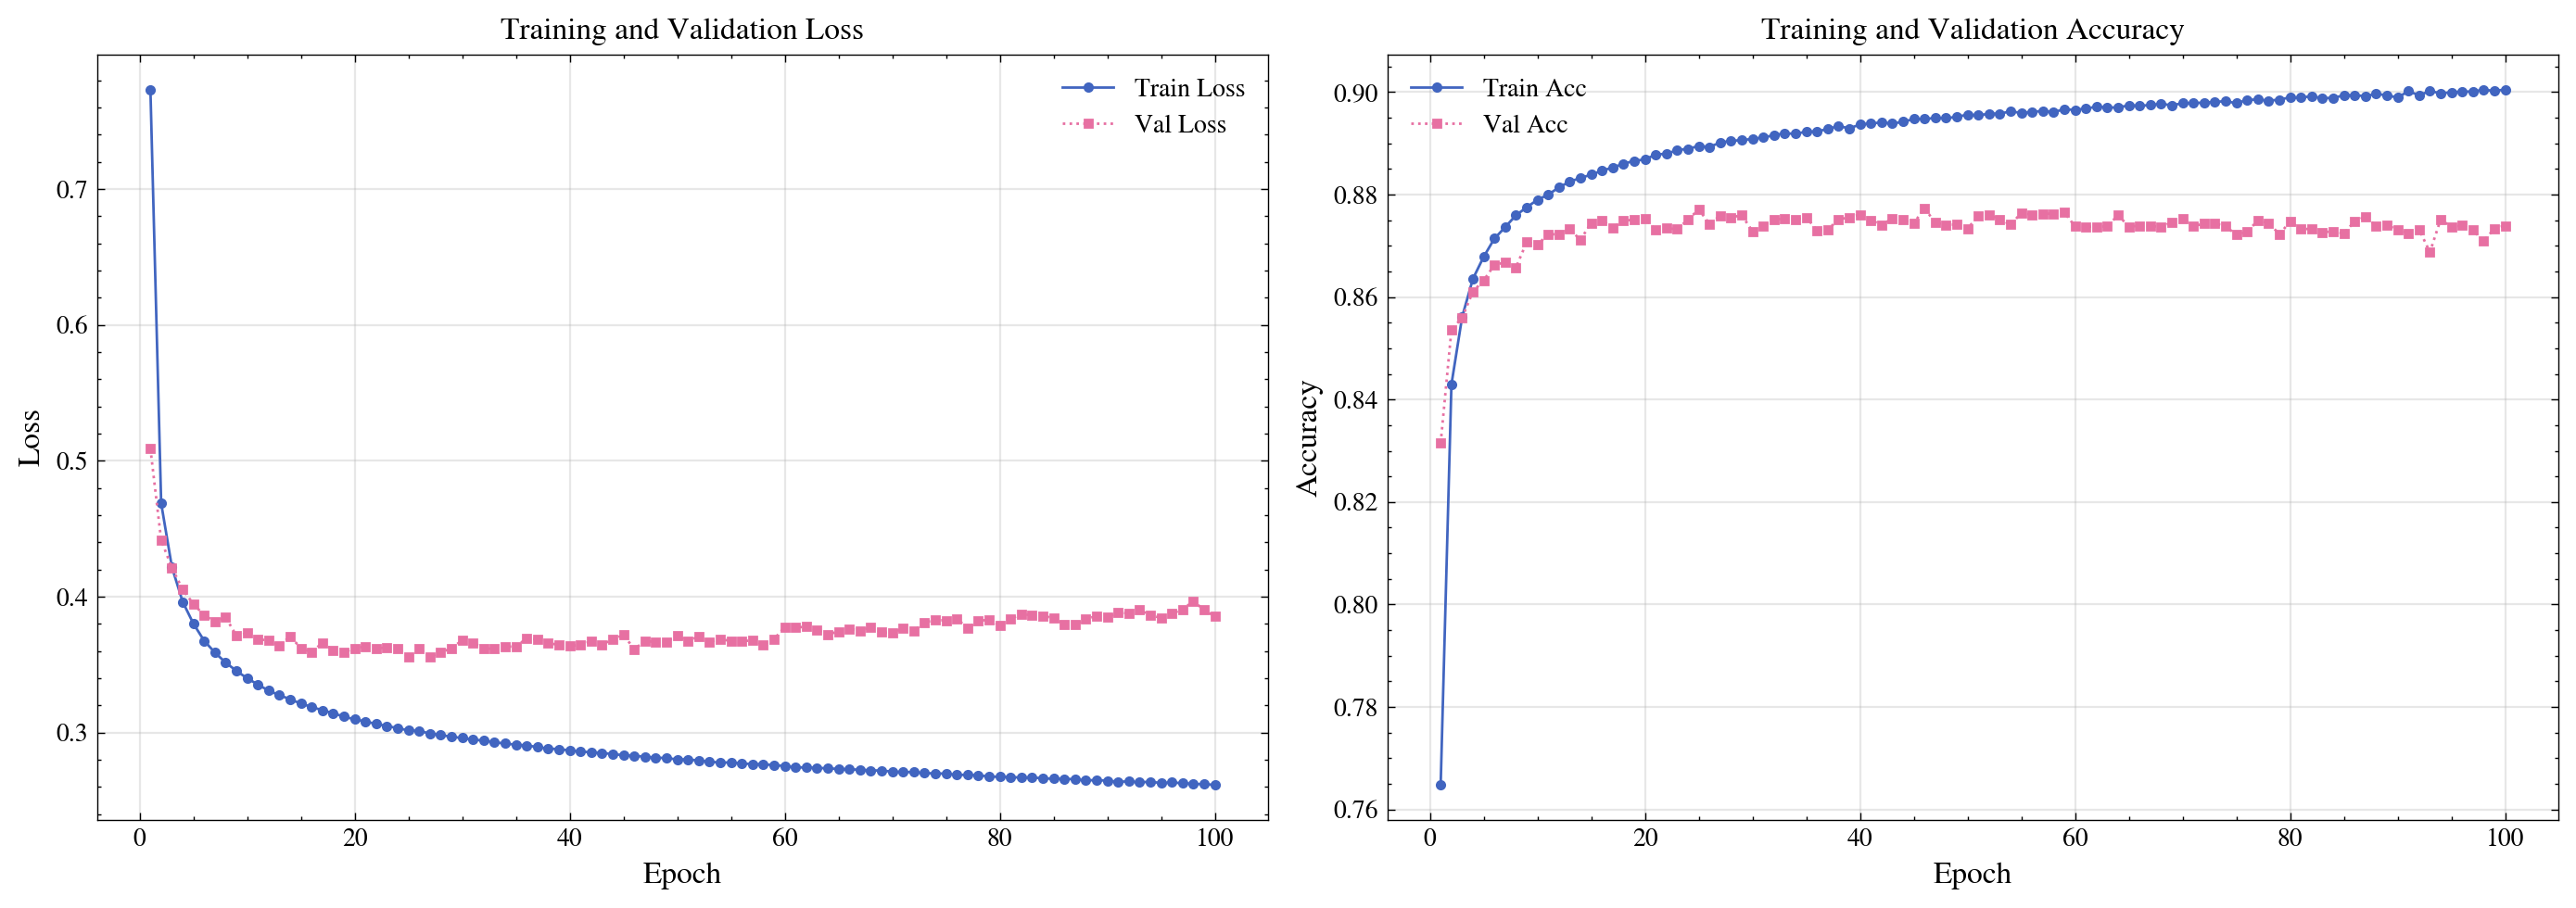

Training curves guardadas en figures/m0_training_history.png


In [10]:
plot_training_history(
    history_m0,
    save_path=project_root / "figures" / "m0_training_history.png",
    figsize=(14, 5),
    style=str(project_root / "figs.mplstyle"),
)
print("Training curves guardadas en figures/m0_training_history.png")

<div style="font-family: Georgia, serif; font-size: 20px; line-height: 1.5;">

<style>
h1 { color: #8db2d7ff; font-weight: 700; }
h2 { color: #4a90e2; font-weight: 500; }
h3 { color: #6b8ea3; font-weight: 400; }
</style>

### 2.2 Modelos M1: Búsqueda de Hiperparámetros

Exploramos 8 variantes M1 organizadas en 4 grupos:

**Grupo 1: Optimizadores**
- M1a: SGD + momentum (0.9) + early stopping
- M1b: Adam + early stopping

**Grupo 2: Regularización**
- M1c: Adam + L2 (λ=0.01)
- M1d: SGD + momentum + L2 + early stopping

**Grupo 3: Learning Rate Scheduling**
- M1e: Adam + Linear LR decay
- M1f: Adam + Exponential LR decay

**Grupo 4: Arquitectura**
- M1g: Deeper [400, 240, 120] + Adam
- M1h: Wider [370, 370] + Adam

Todas las configuraciones de estos experimentos están documentadas en `experiments/configs/configurations.py`.

In [11]:
from experiments.configs.configurations import (
    M1a_CONFIG,
    M1b_CONFIG,
    M1c_CONFIG,
    M1d_CONFIG,
    M1e_CONFIG,
    M1f_CONFIG,
    M1g_CONFIG,
    M1h_CONFIG,
)

<div style="font-family: Georgia, serif; font-size: 20px; line-height: 1.5;">

<style>
h1 { color: #8db2d7ff; font-weight: 700; }
h2 { color: #4a90e2; font-weight: 500; }
h3 { color: #6b8ea3; font-weight: 400; }
</style>


### M1a: SGD + momentum + early stopping

In [12]:
experiment_m1a = Experiment(M1a_CONFIG, dataset)
experiment_m1a.build()
cp.get_default_memory_pool().free_all_blocks()

start_time = time.time()
history_m1a = experiment_m1a.trainer.train(
    X_train,
    y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=M1a_CONFIG.training.epochs,
    batch_size=M1a_CONFIG.training.batch_size,
)
train_time_m1a = time.time() - start_time

print(f"\nM1a Results (Train/Val):")
print(f"  Train Loss: {history_m1a['train_loss'][-1]:.4f}")
print(f"  Train Acc:  {history_m1a['train_metric'][-1]:.4f}")
print(f"  Val Loss:   {history_m1a['val_loss'][-1]:.4f}")
print(f"  Val Acc:    {history_m1a['val_metric'][-1]:.4f}")
print(f"  Time:       {train_time_m1a:.1f}s")

results_manager.save_experiment(
    model_name="M1a",
    config=M1a_CONFIG,
    history=history_m1a,
    test_metrics=None,  
    model=experiment_m1a.model,
    train_time=train_time_m1a,
)

Epoch 1/50 - Loss: 0.8224, Metric: 0.7500, Val Loss: 0.6544, Val Metric: 0.7969
Epoch 2/50 - Loss: 0.6284, Metric: 0.8011, Val Loss: 0.6341, Val Metric: 0.7927
Epoch 3/50 - Loss: 0.5909, Metric: 0.8125, Val Loss: 0.5866, Val Metric: 0.8148
Epoch 4/50 - Loss: 0.5701, Metric: 0.8187, Val Loss: 0.6203, Val Metric: 0.8115
Epoch 5/50 - Loss: 0.5585, Metric: 0.8229, Val Loss: 0.5752, Val Metric: 0.8183
Epoch 6/50 - Loss: 0.5524, Metric: 0.8243, Val Loss: 0.5449, Val Metric: 0.8295
Epoch 7/50 - Loss: 0.5442, Metric: 0.8275, Val Loss: 0.5516, Val Metric: 0.8288
Epoch 8/50 - Loss: 0.5373, Metric: 0.8284, Val Loss: 0.5686, Val Metric: 0.8230
Epoch 9/50 - Loss: 0.5304, Metric: 0.8301, Val Loss: 0.5660, Val Metric: 0.8203
Epoch 10/50 - Loss: 0.5298, Metric: 0.8315, Val Loss: 0.5815, Val Metric: 0.8141
Early stopping at epoch 11

M1a Results (Train/Val):
  Train Loss: 0.5298
  Train Acc:  0.8315
  Val Loss:   0.5815
  Val Acc:    0.8141
  Time:       46.0s

💾 Saving results for M1a...
  📁 Model dir

<div style="font-family: Georgia, serif; font-size: 20px; line-height: 1.5;">

<style>
h1 { color: #8db2d7ff; font-weight: 700; }
h2 { color: #4a90e2; font-weight: 500; }
h3 { color: #6b8ea3; font-weight: 400; }
</style>


### M1b: Adam + early stopping

In [13]:
experiment_m1b = Experiment(M1b_CONFIG, dataset)
experiment_m1b.build()
cp.get_default_memory_pool().free_all_blocks()

start_time = time.time()
history_m1b = experiment_m1b.trainer.train(
    X_train,
    y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=M1b_CONFIG.training.epochs,
    batch_size=M1b_CONFIG.training.batch_size,
)
train_time_m1b = time.time() - start_time

print(f"\nM1b Results (Train/Val):")
print(f"  Train Loss: {history_m1b['train_loss'][-1]:.4f}")
print(f"  Train Acc:  {history_m1b['train_metric'][-1]:.4f}")
print(f"  Val Loss:   {history_m1b['val_loss'][-1]:.4f}")
print(f"  Val Acc:    {history_m1b['val_metric'][-1]:.4f}")
print(f"  Time:       {train_time_m1b:.1f}s")

results_manager.save_experiment(
    model_name="M1b",
    config=M1b_CONFIG,
    history=history_m1b,
    test_metrics=None,
    model=experiment_m1b.model,
    train_time=train_time_m1b,
)

Epoch 1/50 - Loss: 0.8132, Metric: 0.7645, Val Loss: 0.5490, Val Metric: 0.8261
Epoch 2/50 - Loss: 0.5006, Metric: 0.8384, Val Loss: 0.4783, Val Metric: 0.8432
Epoch 3/50 - Loss: 0.4425, Metric: 0.8536, Val Loss: 0.4403, Val Metric: 0.8538
Epoch 4/50 - Loss: 0.4117, Metric: 0.8620, Val Loss: 0.4222, Val Metric: 0.8587
Epoch 5/50 - Loss: 0.3926, Metric: 0.8669, Val Loss: 0.4058, Val Metric: 0.8634
Epoch 6/50 - Loss: 0.3778, Metric: 0.8708, Val Loss: 0.3983, Val Metric: 0.8640
Epoch 7/50 - Loss: 0.3671, Metric: 0.8730, Val Loss: 0.3913, Val Metric: 0.8650
Epoch 8/50 - Loss: 0.3576, Metric: 0.8757, Val Loss: 0.3846, Val Metric: 0.8686
Epoch 9/50 - Loss: 0.3503, Metric: 0.8777, Val Loss: 0.3805, Val Metric: 0.8684
Epoch 10/50 - Loss: 0.3440, Metric: 0.8795, Val Loss: 0.3832, Val Metric: 0.8671
Epoch 11/50 - Loss: 0.3382, Metric: 0.8811, Val Loss: 0.3763, Val Metric: 0.8713
Epoch 12/50 - Loss: 0.3340, Metric: 0.8824, Val Loss: 0.3750, Val Metric: 0.8699
Epoch 13/50 - Loss: 0.3293, Metric: 0

<div style="font-family: Georgia, serif; font-size: 20px; line-height: 1.5;">

<style>
h1 { color: #8db2d7ff; font-weight: 700; }
h2 { color: #4a90e2; font-weight: 500; }
h3 { color: #6b8ea3; font-weight: 400; }
</style>


### M1c: Adam + L2

In [14]:
experiment_m1c = Experiment(M1c_CONFIG, dataset)
experiment_m1c.build()
cp.get_default_memory_pool().free_all_blocks()

start_time = time.time()
history_m1c = experiment_m1c.trainer.train(
    X_train,
    y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=M1c_CONFIG.training.epochs,
    batch_size=M1c_CONFIG.training.batch_size,
)
train_time_m1c = time.time() - start_time

print(f"\nM1c Results (Train/Val):")
print(f"  Train Loss: {history_m1c['train_loss'][-1]:.4f}")
print(f"  Train Acc:  {history_m1c['train_metric'][-1]:.4f}")
print(f"  Val Loss:   {history_m1c['val_loss'][-1]:.4f}")
print(f"  Val Acc:    {history_m1c['val_metric'][-1]:.4f}")
print(f"  Time:       {train_time_m1c:.1f}s")

results_manager.save_experiment(
    model_name="M1c",
    config=M1c_CONFIG,
    history=history_m1c,
    test_metrics=None,
    model=experiment_m1c.model,
    train_time=train_time_m1c,
)

Epoch 1/100 - Loss: 0.8170, Metric: 0.7631, Val Loss: 0.5556, Val Metric: 0.8230
Epoch 2/100 - Loss: 0.5021, Metric: 0.8375, Val Loss: 0.4774, Val Metric: 0.8438
Epoch 3/100 - Loss: 0.4444, Metric: 0.8532, Val Loss: 0.4397, Val Metric: 0.8528
Epoch 4/100 - Loss: 0.4130, Metric: 0.8613, Val Loss: 0.4214, Val Metric: 0.8591
Epoch 5/100 - Loss: 0.3944, Metric: 0.8661, Val Loss: 0.4072, Val Metric: 0.8624
Epoch 6/100 - Loss: 0.3807, Metric: 0.8698, Val Loss: 0.3972, Val Metric: 0.8651
Epoch 7/100 - Loss: 0.3705, Metric: 0.8725, Val Loss: 0.3885, Val Metric: 0.8681
Epoch 8/100 - Loss: 0.3619, Metric: 0.8747, Val Loss: 0.3871, Val Metric: 0.8677
Epoch 9/100 - Loss: 0.3547, Metric: 0.8767, Val Loss: 0.3800, Val Metric: 0.8694
Epoch 10/100 - Loss: 0.3481, Metric: 0.8782, Val Loss: 0.3760, Val Metric: 0.8704
Epoch 11/100 - Loss: 0.3426, Metric: 0.8799, Val Loss: 0.3709, Val Metric: 0.8712
Epoch 12/100 - Loss: 0.3384, Metric: 0.8807, Val Loss: 0.3821, Val Metric: 0.8683
Epoch 13/100 - Loss: 0.33

<div style="font-family: Georgia, serif; font-size: 20px; line-height: 1.5;">

<style>
h1 { color: #8db2d7ff; font-weight: 700; }
h2 { color: #4a90e2; font-weight: 500; }
h3 { color: #6b8ea3; font-weight: 400; }
</style>


### M1d: SGD + momentum + L2 + early stopping

In [15]:
experiment_m1d = Experiment(M1d_CONFIG, dataset)
experiment_m1d.build()
cp.get_default_memory_pool().free_all_blocks()

start_time = time.time()
history_m1d = experiment_m1d.trainer.train(
    X_train,
    y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=M1d_CONFIG.training.epochs,
    batch_size=M1d_CONFIG.training.batch_size,
)
train_time_m1d = time.time() - start_time

print(f"\nM1d Results (Train/Val):")
print(f"  Train Loss: {history_m1d['train_loss'][-1]:.4f}")
print(f"  Train Acc:  {history_m1d['train_metric'][-1]:.4f}")
print(f"  Val Loss:   {history_m1d['val_loss'][-1]:.4f}")
print(f"  Val Acc:    {history_m1d['val_metric'][-1]:.4f}")
print(f"  Time:       {train_time_m1d:.1f}s")

results_manager.save_experiment(
    model_name="M1d",
    config=M1d_CONFIG,
    history=history_m1d,
    test_metrics=None,
    model=experiment_m1d.model,
    train_time=train_time_m1d,
)

Epoch 1/100 - Loss: 0.7849, Metric: 0.7594, Val Loss: 0.6472, Val Metric: 0.7909
Epoch 2/100 - Loss: 0.5994, Metric: 0.8090, Val Loss: 0.5922, Val Metric: 0.8123
Epoch 3/100 - Loss: 0.5647, Metric: 0.8196, Val Loss: 0.5608, Val Metric: 0.8196
Epoch 4/100 - Loss: 0.5491, Metric: 0.8237, Val Loss: 0.5616, Val Metric: 0.8229
Epoch 5/100 - Loss: 0.5357, Metric: 0.8269, Val Loss: 0.5629, Val Metric: 0.8214
Epoch 6/100 - Loss: 0.5287, Metric: 0.8285, Val Loss: 0.5394, Val Metric: 0.8193
Epoch 7/100 - Loss: 0.5157, Metric: 0.8327, Val Loss: 0.5328, Val Metric: 0.8274
Epoch 8/100 - Loss: 0.5119, Metric: 0.8340, Val Loss: 0.5100, Val Metric: 0.8309
Epoch 9/100 - Loss: 0.5065, Metric: 0.8353, Val Loss: 0.5365, Val Metric: 0.8282
Epoch 10/100 - Loss: 0.5033, Metric: 0.8368, Val Loss: 0.5413, Val Metric: 0.8295
Epoch 11/100 - Loss: 0.5008, Metric: 0.8369, Val Loss: 0.5277, Val Metric: 0.8338
Epoch 12/100 - Loss: 0.4992, Metric: 0.8373, Val Loss: 0.5227, Val Metric: 0.8344
Epoch 13/100 - Loss: 0.49

<div style="font-family: Georgia, serif; font-size: 20px; line-height: 1.5;">

<style>
h1 { color: #8db2d7ff; font-weight: 700; }
h2 { color: #4a90e2; font-weight: 500; }
h3 { color: #6b8ea3; font-weight: 400; }
</style>


### M1e: Adam + Linear LR decay

In [16]:
experiment_m1e = Experiment(M1e_CONFIG, dataset)
experiment_m1e.build()
cp.get_default_memory_pool().free_all_blocks()

start_time = time.time()
history_m1e = experiment_m1e.trainer.train(
    X_train,
    y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=M1e_CONFIG.training.epochs,
    batch_size=M1e_CONFIG.training.batch_size,
)
train_time_m1e = time.time() - start_time

print(f"\nM1e Results (Train/Val):")
print(f"  Train Loss: {history_m1e['train_loss'][-1]:.4f}")
print(f"  Train Acc:  {history_m1e['train_metric'][-1]:.4f}")
print(f"  Val Loss:   {history_m1e['val_loss'][-1]:.4f}")
print(f"  Val Acc:    {history_m1e['val_metric'][-1]:.4f}")
print(f"  Time:       {train_time_m1e:.1f}s")

results_manager.save_experiment(
    model_name="M1e",
    config=M1e_CONFIG,
    history=history_m1e,
    test_metrics=None,
    model=experiment_m1e.model,
    train_time=train_time_m1e,
)

Epoch 1/100 - Loss: 0.8140, Metric: 0.7649, Val Loss: 0.5579, Val Metric: 0.8209
Epoch 2/100 - Loss: 0.4976, Metric: 0.8396, Val Loss: 0.4749, Val Metric: 0.8450
Epoch 3/100 - Loss: 0.4401, Metric: 0.8547, Val Loss: 0.4373, Val Metric: 0.8536
Epoch 4/100 - Loss: 0.4090, Metric: 0.8622, Val Loss: 0.4139, Val Metric: 0.8601
Epoch 5/100 - Loss: 0.3900, Metric: 0.8675, Val Loss: 0.4078, Val Metric: 0.8608
Epoch 6/100 - Loss: 0.3751, Metric: 0.8713, Val Loss: 0.4037, Val Metric: 0.8627
Epoch 7/100 - Loss: 0.3637, Metric: 0.8746, Val Loss: 0.3881, Val Metric: 0.8666
Epoch 8/100 - Loss: 0.3555, Metric: 0.8765, Val Loss: 0.3830, Val Metric: 0.8685
Epoch 9/100 - Loss: 0.3483, Metric: 0.8783, Val Loss: 0.3808, Val Metric: 0.8692
Epoch 10/100 - Loss: 0.3419, Metric: 0.8802, Val Loss: 0.3775, Val Metric: 0.8703
Epoch 11/100 - Loss: 0.3361, Metric: 0.8816, Val Loss: 0.3735, Val Metric: 0.8703
Epoch 12/100 - Loss: 0.3315, Metric: 0.8829, Val Loss: 0.3709, Val Metric: 0.8705
Epoch 13/100 - Loss: 0.32

<div style="font-family: Georgia, serif; font-size: 20px; line-height: 1.5;">

<style>
h1 { color: #8db2d7ff; font-weight: 700; }
h2 { color: #4a90e2; font-weight: 500; }
h3 { color: #6b8ea3; font-weight: 400; }
</style>


### M1f: Adam + Exponential LR decay

In [17]:
experiment_m1f = Experiment(M1f_CONFIG, dataset)
experiment_m1f.build()
cp.get_default_memory_pool().free_all_blocks()

start_time = time.time()
history_m1f = experiment_m1f.trainer.train(
    X_train,
    y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=M1f_CONFIG.training.epochs,
    batch_size=M1f_CONFIG.training.batch_size,
)
train_time_m1f = time.time() - start_time

print(f"\nM1f Results (Train/Val):")
print(f"  Train Loss: {history_m1f['train_loss'][-1]:.4f}")
print(f"  Train Acc:  {history_m1f['train_metric'][-1]:.4f}")
print(f"  Val Loss:   {history_m1f['val_loss'][-1]:.4f}")
print(f"  Val Acc:    {history_m1f['val_metric'][-1]:.4f}")
print(f"  Time:       {train_time_m1f:.1f}s")

results_manager.save_experiment(
    model_name="M1f",
    config=M1f_CONFIG,
    history=history_m1f,
    test_metrics=None,
    model=experiment_m1f.model,
    train_time=train_time_m1f,
)

Epoch 1/100 - Loss: 0.8117, Metric: 0.7648, Val Loss: 0.5475, Val Metric: 0.8266
Epoch 2/100 - Loss: 0.4986, Metric: 0.8391, Val Loss: 0.4719, Val Metric: 0.8453
Epoch 3/100 - Loss: 0.4417, Metric: 0.8539, Val Loss: 0.4493, Val Metric: 0.8499
Epoch 4/100 - Loss: 0.4126, Metric: 0.8615, Val Loss: 0.4224, Val Metric: 0.8578
Epoch 5/100 - Loss: 0.3925, Metric: 0.8666, Val Loss: 0.4022, Val Metric: 0.8634
Epoch 6/100 - Loss: 0.3774, Metric: 0.8707, Val Loss: 0.3986, Val Metric: 0.8641
Epoch 7/100 - Loss: 0.3661, Metric: 0.8738, Val Loss: 0.3890, Val Metric: 0.8654
Epoch 8/100 - Loss: 0.3570, Metric: 0.8762, Val Loss: 0.3850, Val Metric: 0.8676
Epoch 9/100 - Loss: 0.3492, Metric: 0.8780, Val Loss: 0.3813, Val Metric: 0.8695
Epoch 10/100 - Loss: 0.3426, Metric: 0.8797, Val Loss: 0.3747, Val Metric: 0.8723
Epoch 11/100 - Loss: 0.3369, Metric: 0.8817, Val Loss: 0.3691, Val Metric: 0.8730
Epoch 12/100 - Loss: 0.3316, Metric: 0.8829, Val Loss: 0.3747, Val Metric: 0.8696
Epoch 13/100 - Loss: 0.32

<div style="font-family: Georgia, serif; font-size: 20px; line-height: 1.5;">

<style>
h1 { color: #8db2d7ff; font-weight: 700; }
h2 { color: #4a90e2; font-weight: 500; }
h3 { color: #6b8ea3; font-weight: 400; }
</style>


### M1g: Deeper architecture [400, 240, 120]

In [18]:
experiment_m1g = Experiment(M1g_CONFIG, dataset)
experiment_m1g.build()
cp.get_default_memory_pool().free_all_blocks()

start_time = time.time()
history_m1g = experiment_m1g.trainer.train(
    X_train,
    y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=M1g_CONFIG.training.epochs,
    batch_size=M1g_CONFIG.training.batch_size,
)
train_time_m1g = time.time() - start_time

print(f"\nM1g Results (Train/Val):")
print(f"  Train Loss: {history_m1g['train_loss'][-1]:.4f}")
print(f"  Train Acc:  {history_m1g['train_metric'][-1]:.4f}")
print(f"  Val Loss:   {history_m1g['val_loss'][-1]:.4f}")
print(f"  Val Acc:    {history_m1g['val_metric'][-1]:.4f}")
print(f"  Time:       {train_time_m1g:.1f}s")

results_manager.save_experiment(
    model_name="M1g",
    config=M1g_CONFIG,
    history=history_m1g,
    test_metrics=None,
    model=experiment_m1g.model,
    train_time=train_time_m1g,
)

Epoch 1/50 - Loss: 0.6005, Metric: 0.8130, Val Loss: 0.4191, Val Metric: 0.8548
Epoch 2/50 - Loss: 0.3738, Metric: 0.8698, Val Loss: 0.3744, Val Metric: 0.8705
Epoch 3/50 - Loss: 0.3337, Metric: 0.8806, Val Loss: 0.3489, Val Metric: 0.8750
Epoch 4/50 - Loss: 0.3113, Metric: 0.8870, Val Loss: 0.3376, Val Metric: 0.8801
Epoch 5/50 - Loss: 0.2950, Metric: 0.8912, Val Loss: 0.3313, Val Metric: 0.8813
Epoch 6/50 - Loss: 0.2817, Metric: 0.8954, Val Loss: 0.3328, Val Metric: 0.8804
Epoch 7/50 - Loss: 0.2706, Metric: 0.8978, Val Loss: 0.3290, Val Metric: 0.8833
Epoch 8/50 - Loss: 0.2608, Metric: 0.9007, Val Loss: 0.3346, Val Metric: 0.8807
Epoch 9/50 - Loss: 0.2525, Metric: 0.9030, Val Loss: 0.3331, Val Metric: 0.8837
Epoch 10/50 - Loss: 0.2455, Metric: 0.9049, Val Loss: 0.3398, Val Metric: 0.8833
Epoch 11/50 - Loss: 0.2393, Metric: 0.9066, Val Loss: 0.3322, Val Metric: 0.8851
Early stopping at epoch 12

M1g Results (Train/Val):
  Train Loss: 0.2393
  Train Acc:  0.9066
  Val Loss:   0.3322
  

<div style="font-family: Georgia, serif; font-size: 20px; line-height: 1.5;">

<style>
h1 { color: #8db2d7ff; font-weight: 700; }
h2 { color: #4a90e2; font-weight: 500; }
h3 { color: #6b8ea3; font-weight: 400; }
</style>


### M1h: Wider architecture [370, 370]

In [19]:
experiment_m1h = Experiment(M1h_CONFIG, dataset)
experiment_m1h.build()
cp.get_default_memory_pool().free_all_blocks()

start_time = time.time()
history_m1h = experiment_m1h.trainer.train(
    X_train,
    y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=M1h_CONFIG.training.epochs,
    batch_size=M1h_CONFIG.training.batch_size,
)
train_time_m1h = time.time() - start_time

print(f"\nM1h Results (Train/Val):")
print(f"  Train Loss: {history_m1h['train_loss'][-1]:.4f}")
print(f"  Train Acc:  {history_m1h['train_metric'][-1]:.4f}")
print(f"  Val Loss:   {history_m1h['val_loss'][-1]:.4f}")
print(f"  Val Acc:    {history_m1h['val_metric'][-1]:.4f}")
print(f"  Time:       {train_time_m1h:.1f}s")

results_manager.save_experiment(
    model_name="M1h",
    config=M1h_CONFIG,
    history=history_m1h,
    test_metrics=None,
    model=experiment_m1h.model,
    train_time=train_time_m1h,
)

Epoch 1/50 - Loss: 0.5935, Metric: 0.8157, Val Loss: 0.4118, Val Metric: 0.8609
Epoch 2/50 - Loss: 0.3730, Metric: 0.8712, Val Loss: 0.3694, Val Metric: 0.8725
Epoch 3/50 - Loss: 0.3322, Metric: 0.8818, Val Loss: 0.3490, Val Metric: 0.8755
Epoch 4/50 - Loss: 0.3087, Metric: 0.8881, Val Loss: 0.3388, Val Metric: 0.8794
Epoch 5/50 - Loss: 0.2914, Metric: 0.8928, Val Loss: 0.3334, Val Metric: 0.8818
Epoch 6/50 - Loss: 0.2777, Metric: 0.8967, Val Loss: 0.3246, Val Metric: 0.8838
Epoch 7/50 - Loss: 0.2662, Metric: 0.8998, Val Loss: 0.3323, Val Metric: 0.8825
Epoch 8/50 - Loss: 0.2564, Metric: 0.9021, Val Loss: 0.3284, Val Metric: 0.8830
Epoch 9/50 - Loss: 0.2474, Metric: 0.9043, Val Loss: 0.3270, Val Metric: 0.8857
Epoch 10/50 - Loss: 0.2394, Metric: 0.9068, Val Loss: 0.3374, Val Metric: 0.8823
Early stopping at epoch 11

M1h Results (Train/Val):
  Train Loss: 0.2394
  Train Acc:  0.9068
  Val Loss:   0.3374
  Val Acc:    0.8823
  Time:       173.9s

💾 Saving results for M1h...
  📁 Model di

### Comparación de modelos M1

In [20]:
m1_models = ["M1a", "M1b", "M1c", "M1d", "M1e", "M1f", "M1g", "M1h"]
m1_val_comparison = []

for name in m1_models:
    data = results_manager.load_results(name)
    train_acc = data["history"]["train_metric"][-1]
    train_loss = data["history"]["train_loss"][-1]
    val_acc = data["history"]["val_metric"][-1]
    val_loss = data["history"]["val_loss"][-1]
    m1_val_comparison.append((name, train_acc, train_loss, val_acc, val_loss))

m1_val_comparison.sort(key=lambda x: x[3], reverse=True)

print(f"\n{'Rank':<6} {'Model':<10} {'Train Acc':<12} {'Val Acc':<12} {'Val Loss':<12}")
print("-" * 60)
for rank, (name, train_acc, train_loss, val_acc, val_loss) in enumerate(
    m1_val_comparison, 1
):
    marker = "⭐" if rank == 1 else "  "
    print(
        f"{marker} {rank:<4} {name:<10} {train_acc:<12.4f} {val_acc:<12.4f} {val_loss:<12.4f}"
    )

best_m1_name = m1_val_comparison[0][0]
best_m1_val_acc = m1_val_comparison[0][3]
best_m1_val_loss = m1_val_comparison[0][4]

print(f"\n MODELO M1 SELECCIONADO: {best_m1_name}")
print(f"   Val Accuracy: {best_m1_val_acc:.4f}")
print(f"   Val Loss:     {best_m1_val_loss:.4f}")
print("\nEvaluación en test se realizará al final en sección 4.c")
print("=" * 70)


📂 Loading results for M1a...
  ✓ Loaded metadata
  ✓ Loaded training history
  ✓ Loaded confusion matrix
  ✓ Loaded model weights
✓ All results loaded for M1a


📂 Loading results for M1b...
  ✓ Loaded metadata
  ✓ Loaded training history
  ✓ Loaded confusion matrix
  ✓ Loaded model weights
✓ All results loaded for M1b


📂 Loading results for M1c...
  ✓ Loaded metadata
  ✓ Loaded training history
  ✓ Loaded confusion matrix
  ✓ Loaded model weights
✓ All results loaded for M1c


📂 Loading results for M1d...
  ✓ Loaded metadata
  ✓ Loaded training history
  ✓ Loaded confusion matrix
  ✓ Loaded model weights
✓ All results loaded for M1d


📂 Loading results for M1e...
  ✓ Loaded metadata
  ✓ Loaded training history
  ✓ Loaded confusion matrix
  ✓ Loaded model weights
✓ All results loaded for M1e


📂 Loading results for M1f...
  ✓ Loaded metadata
  ✓ Loaded training history
  ✓ Loaded confusion matrix
  ✓ Loaded model weights
✓ All results loaded for M1f


📂 Loading results for M1g...
  ✓ 

<div style="font-family: Georgia, serif; font-size: 20px; line-height: 1.5;">

<style>
h1 { color: #8db2d7ff; font-weight: 700; }
h2 { color: #4a90e2; font-weight: 500; }
h3 { color: #6b8ea3; font-weight: 400; }
</style>

## 3. Implementación con PyTorch

En esta sección implementamos modelos equivalentes usando **PyTorch**, el framework
de deep learning más popular. Esto nos permite:
- **Validar** nuestra implementación custom comparando resultados
- **Explorar** arquitecturas modernas y funciones de activación
- **Aprovechar** optimizaciones y aceleración GPU de PyTorch

### 3.1 Modelo M2: Validación de implementación

**Objetivo:** Validar que nuestra implementación custom es correcta comparándola con PyTorch.

**Configuración M2:**
- **Misma arquitectura** que el mejor modelo M1
- **Mismo optimizador** (Adam)
- **Mismos hiperparámetros** (learning rate, batch size, etc.)

Si M2 obtiene resultados similares a M1, confirmamos que nuestra implementación
custom funciona correctamente.

In [21]:
import torch
from experiments.configs.pytorch_configs import M2_CONFIG
from experiments.pytorch_runner import PyTorchExperiment

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [22]:
print("MODELO M2 - PyTorch Baseline")
print("=" * 70)
print(f"Nombre: {M2_CONFIG.name}")
print(f"Descripción: {M2_CONFIG.description}")
print(f"\nArquitectura:")
print(f"  Hidden layers: {M2_CONFIG.hidden_layers}")
print(f"  Activación: {M2_CONFIG.activation}")
print(f"  Dropout: {M2_CONFIG.dropout_rate}")
print(f"  Batch Norm: {M2_CONFIG.use_batch_norm}")
print(f"\nOptimizador:")
print(f"  Tipo: {M2_CONFIG.optimizer_type.upper()}")
print(f"  Learning rate: {M2_CONFIG.learning_rate}")
print(f"  Weight decay (L2): {M2_CONFIG.weight_decay}")
print(f"\nHiperparámetros:")
print(f"  Batch size: {M2_CONFIG.batch_size}")
print(f"  Épocas: {M2_CONFIG.epochs}")
print(f"  Early stopping: {M2_CONFIG.early_stopping} (patience={M2_CONFIG.patience})")

MODELO M2 - PyTorch Baseline
Nombre: M2
Descripción: PyTorch baseline - matches best M1 architecture (Adam + early stopping)

Arquitectura:
  Hidden layers: [400, 240, 120]
  Activación: relu
  Dropout: 0.0
  Batch Norm: False

Optimizador:
  Tipo: ADAM
  Learning rate: 0.001
  Weight decay (L2): 0.0

Hiperparámetros:
  Batch size: 512
  Épocas: 50
  Early stopping: True (patience=5)


In [23]:
import time

experiment_m2 = PyTorchExperiment(M2_CONFIG)
experiment_m2.build()

cp.get_default_memory_pool().free_all_blocks()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("Memoria GPU liberada\n")

print("Entrenando M2 (PyTorch)...")
start_time = time.time()
history_m2 = experiment_m2.train(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
)
train_time_m2 = time.time() - start_time

print("\nEntrenamiento M2 completado")
print(f"Tiempo total: {train_time_m2:.2f} segundos ({train_time_m2/60:.2f} minutos)")
print(f"Loss final (train): {history_m2['train_loss'][-1]:.4f}")
print(f"Accuracy final (train): {history_m2['train_metric'][-1]:.4f}")
print(f"Loss final (val): {history_m2['val_loss'][-1]:.4f}")
print(f"Accuracy final (val): {history_m2['val_metric'][-1]:.4f}")


PyTorch Model: M2
Description: PyTorch baseline - matches best M1 architecture (Adam + early stopping)
Architecture:
  Input: 784
  Hidden 1: 400 (relu)
  Hidden 2: 240 (relu)
  Hidden 3: 120 (relu)
  Output: 47

Optimizer: ADAM
  LR: 0.001

Training:
  Batch size: 512
  Epochs: 50
  Early stopping: patience=5

Total parameters: 444,847

Memoria GPU liberada

Entrenando M2 (PyTorch)...

Training PyTorch model on cuda
Epoch 1/50 (4.89s) - Loss: 0.5933 - Acc: 0.8143 - Val Loss: 0.4144 - Val Acc: 0.8573 - LR: 0.001000
Epoch 2/50 (4.65s) - Loss: 0.3735 - Acc: 0.8701 - Val Loss: 0.3724 - Val Acc: 0.8690 - LR: 0.001000
Epoch 3/50 (4.62s) - Loss: 0.3335 - Acc: 0.8808 - Val Loss: 0.3523 - Val Acc: 0.8759 - LR: 0.001000
Epoch 4/50 (4.69s) - Loss: 0.3115 - Acc: 0.8871 - Val Loss: 0.3414 - Val Acc: 0.8785 - LR: 0.001000
Epoch 5/50 (4.67s) - Loss: 0.2947 - Acc: 0.8918 - Val Loss: 0.3332 - Val Acc: 0.8818 - LR: 0.001000
Epoch 6/50 (4.44s) - Loss: 0.2827 - Acc: 0.8949 - Val Loss: 0.3346 - Val Acc: 

In [24]:
print("\n" + "=" * 70)
print("VALIDACIÓN: M1 (Custom) vs M2 (PyTorch)")
print("=" * 70)

best_m1_data = results_manager.load_results(best_m1_name)
m1_train_acc = best_m1_data["history"]["train_metric"][-1]
m1_val_acc = best_m1_data["history"]["val_metric"][-1]
m1_val_loss = best_m1_data["history"]["val_loss"][-1]

m2_train_acc = history_m2["train_metric"][-1]
m2_val_acc = history_m2["val_metric"][-1]
m2_val_loss = history_m2["val_loss"][-1]

print(f"\n{'Model':<25} {'Train Acc':<12} {'Val Acc':<12} {'Val Loss':<12}")
print("-" * 70)
print(
    f"{best_m1_name + ' (Custom)':<25} {m1_train_acc:<12.4f} {m1_val_acc:<12.4f} {m1_val_loss:<12.4f}"
)
print(
    f"{'M2 (PyTorch)':<25} {m2_train_acc:<12.4f} {m2_val_acc:<12.4f} {m2_val_loss:<12.4f}"
)


acc_diff = abs(m1_val_acc - m2_val_acc)
loss_diff = abs(m1_val_loss - m2_val_loss)

print(f"\nDiferencias en validación:")
print(f"  Δ Val Accuracy: {acc_diff:.4f} ({acc_diff*100:.2f}%)")
print(f"  Δ Val Loss:     {loss_diff:.4f}")

if acc_diff < 0.02:
    print("\n VALIDACIÓN EXITOSA: Implementaciones equivalentes (<2% diferencia)")
    print("   → La implementación custom funciona correctamente")
else:
    print("\n  DIFERENCIA NOTABLE: Revisar implementación o inicialización")



VALIDACIÓN: M1 (Custom) vs M2 (PyTorch)

📂 Loading results for M1g...
  ✓ Loaded metadata
  ✓ Loaded training history
  ✓ Loaded confusion matrix
  ✓ Loaded model weights
✓ All results loaded for M1g


Model                     Train Acc    Val Acc      Val Loss    
----------------------------------------------------------------------
M1g (Custom)              0.9066       0.8851       0.3322      
M2 (PyTorch)              0.9099       0.8823       0.3494      

Diferencias en validación:
  Δ Val Accuracy: 0.0028 (0.28%)
  Δ Val Loss:     0.0172

 VALIDACIÓN EXITOSA: Implementaciones equivalentes (<2% diferencia)
   → La implementación custom funciona correctamente


In [25]:
import json

m2_results_data = {
    "name": M2_CONFIG.name,
    "description": M2_CONFIG.description,
    "framework": "PyTorch",
    "config": {
        "hidden_layers": M2_CONFIG.hidden_layers,
        "activation": M2_CONFIG.activation,
        "dropout_rate": M2_CONFIG.dropout_rate,
        "use_batch_norm": M2_CONFIG.use_batch_norm,
        "optimizer": M2_CONFIG.optimizer_type,
        "learning_rate": M2_CONFIG.learning_rate,
        "weight_decay": M2_CONFIG.weight_decay,
        "batch_size": M2_CONFIG.batch_size,
        "epochs": M2_CONFIG.epochs,
        "early_stopping": M2_CONFIG.early_stopping,
        "patience": M2_CONFIG.patience,
    },
    "train_time": train_time_m2,
    "final_train_acc": float(history_m2["train_metric"][-1]),
    "final_val_acc": float(history_m2["val_metric"][-1]),
}

with open(project_root / "results" / "m2_results.json", "w") as f:
    json.dump(m2_results_data, f, indent=2)

np.savez(
    project_root / "results" / "m2_history.npz",
    train_loss=np.array(history_m2["train_loss"]),
    train_metric=np.array(history_m2["train_metric"]),
    val_loss=np.array(history_m2["val_loss"]),
    val_metric=np.array(history_m2["val_metric"]),
    learning_rates=np.array(history_m2["learning_rates"]),
)

print("\n Resultados M2 guardados en results/")
print("  - m2_results.json (metadata)")
print("  - m2_history.npz (training curves)")


 Resultados M2 guardados en results/
  - m2_results.json (metadata)
  - m2_history.npz (training curves)


<div style="font-family: Georgia, serif; font-size: 20px; line-height: 1.5;">

<style>
h1 { color: #8db2d7ff; font-weight: 700; }
h2 { color: #4a90e2; font-weight: 500; }
h3 { color: #6b8ea3; font-weight: 400; }
</style>

### 3.2 Modelos M3: Arquitecturas modernas

**Objetivo:** Explorar arquitecturas modernas con PyTorch para mejorar performance.

**Variantes M3:**
- **M3a:** Deeper [256, 128, 64, 64] + GELU + Dropout(0.2) + Weight Decay
- **M3b:** Wider [400, 400] + SiLU (Swish) + BatchNorm + Dropout(0.3) + Weight Decay

**Novedades respecto a M1/M2:**
- **Activaciones modernas:** GELU (Gaussian Error Linear Unit), SiLU (Sigmoid Linear Unit / Swish)
- **Regularización avanzada:** Dropout + BatchNorm + Weight Decay (L2)
- **Arquitecturas optimizadas:** Balance entre profundidad y ancho
- **Early stopping agresivo:** Patience=7 para evitar overfitting

In [26]:
from experiments.configs.pytorch_configs import (
    M3a_CONFIG,
    M3b_CONFIG,
    M3_CONFIGS,
)

### M3a: Deeper [256, 128, 64, 64] + GELU + Dropout(0.2)

In [27]:
experiment_m3a = PyTorchExperiment(M3a_CONFIG)
experiment_m3a.build()

cp.get_default_memory_pool().free_all_blocks()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print(" Memoria GPU liberada\n")

print(" Entrenando M3a...")
start_time = time.time()
history_m3a = experiment_m3a.train(X_train, y_train, X_val, y_val)
train_time_m3a = time.time() - start_time

print(f"\nM3a Results (Train/Val):")
print(f"  Train Loss: {history_m3a['train_loss'][-1]:.4f}")
print(f"  Train Acc:  {history_m3a['train_metric'][-1]:.4f}")
print(f"  Val Loss:   {history_m3a['val_loss'][-1]:.4f}")
print(f"  Val Acc:    {history_m3a['val_metric'][-1]:.4f}")
print(f"  Time:       {train_time_m3a:.1f}s ({train_time_m3a/60:.2f} min)")


PyTorch Model: M3a
Description: Deeper [256, 128, 64, 64] + GELU + Dropout(0.2) + weight decay + early stopping + patience=7
Architecture:
  Input: 784
  Hidden 1: 256 (gelu)
    → Dropout(0.2)
  Hidden 2: 128 (gelu)
    → Dropout(0.2)
  Hidden 3: 64 (gelu)
    → Dropout(0.2)
  Hidden 4: 64 (gelu)
    → Dropout(0.2)
  Output: 47

Optimizer: ADAM
  LR: 0.001
  Weight decay (L2): 0.0001

Training:
  Batch size: 512
  Epochs: 50
  Early stopping: patience=7

Total parameters: 249,327

 Memoria GPU liberada

 Entrenando M3a...

Training PyTorch model on cuda
Epoch 1/50 (4.87s) - Loss: 1.0059 - Acc: 0.7059 - Val Loss: 0.4821 - Val Acc: 0.8391 - LR: 0.001000
Epoch 2/50 (4.72s) - Loss: 0.5903 - Acc: 0.8123 - Val Loss: 0.4129 - Val Acc: 0.8570 - LR: 0.001000
Epoch 3/50 (4.68s) - Loss: 0.5208 - Acc: 0.8313 - Val Loss: 0.3855 - Val Acc: 0.8657 - LR: 0.001000
Epoch 4/50 (4.63s) - Loss: 0.4873 - Acc: 0.8404 - Val Loss: 0.3707 - Val Acc: 0.8694 - LR: 0.001000
Epoch 5/50 (4.76s) - Loss: 0.4659 - Ac

### M3b: Wider [400, 400] + SiLU + BatchNorm + Dropout

In [28]:
experiment_m3b = PyTorchExperiment(M3b_CONFIG)
experiment_m3b.build()

cp.get_default_memory_pool().free_all_blocks()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("Memoria GPU liberada\n")

print("Entrenando M3b...")
start_time = time.time()
history_m3b = experiment_m3b.train(X_train, y_train, X_val, y_val)
train_time_m3b = time.time() - start_time

print(f"\nM3b Results (Train/Val):")
print(f"  Train Loss: {history_m3b['train_loss'][-1]:.4f}")
print(f"  Train Acc:  {history_m3b['train_metric'][-1]:.4f}")
print(f"  Val Loss:   {history_m3b['val_loss'][-1]:.4f}")
print(f"  Val Acc:    {history_m3b['val_metric'][-1]:.4f}")
print(f"  Time:       {train_time_m3b:.1f}s ({train_time_m3b/60:.2f} min)")


PyTorch Model: M3b
Description: Wider [400, 400] + SiLU + BatchNorm + Dropout(0.3) + weight decay + early stopping + patience=7
Architecture:
  Input: 784
  Hidden 1: 400 (silu)
    → Dropout(0.3)
    → BatchNorm
  Hidden 2: 400 (silu)
    → Dropout(0.3)
    → BatchNorm
  Output: 47

Optimizer: ADAM
  LR: 0.001
  Weight decay (L2): 0.0001

Training:
  Batch size: 512
  Epochs: 50
  Early stopping: patience=7

Total parameters: 494,847

Memoria GPU liberada

Entrenando M3b...

Training PyTorch model on cuda
Epoch 1/50 (5.76s) - Loss: 0.7092 - Acc: 0.7812 - Val Loss: 0.4304 - Val Acc: 0.8540 - LR: 0.001000
Epoch 2/50 (5.19s) - Loss: 0.4746 - Acc: 0.8420 - Val Loss: 0.3792 - Val Acc: 0.8684 - LR: 0.001000
Epoch 3/50 (5.00s) - Loss: 0.4305 - Acc: 0.8543 - Val Loss: 0.3577 - Val Acc: 0.8740 - LR: 0.001000
Epoch 4/50 (4.82s) - Loss: 0.4088 - Acc: 0.8598 - Val Loss: 0.3490 - Val Acc: 0.8772 - LR: 0.001000
Epoch 5/50 (4.83s) - Loss: 0.3959 - Acc: 0.8634 - Val Loss: 0.3405 - Val Acc: 0.8795 - 

### Comparación de modelos M3

In [29]:
print("\n" + "=" * 70)
print("SELECCIÓN DEL MEJOR MODELO M3 (basado en validación)")
print("=" * 70)

m3_models = ["M3a", "M3b"]
m3_histories = {
    "M3a": history_m3a,
    "M3b": history_m3b,
}

m3_val_comparison = []
for name in m3_models:
    train_acc = m3_histories[name]["train_metric"][-1]
    train_loss = m3_histories[name]["train_loss"][-1]
    val_acc = m3_histories[name]["val_metric"][-1]
    val_loss = m3_histories[name]["val_loss"][-1]
    m3_val_comparison.append((name, train_acc, train_loss, val_acc, val_loss))

m3_val_comparison.sort(key=lambda x: x[3], reverse=True)

print(f"\n{'Rank':<6} {'Model':<10} {'Train Acc':<12} {'Val Acc':<12} {'Val Loss':<12}")
print("-" * 60)
for rank, (name, train_acc, train_loss, val_acc, val_loss) in enumerate(
    m3_val_comparison, 1
):
    marker = "⭐" if rank == 1 else "  "
    print(
        f"{marker} {rank:<4} {name:<10} {train_acc:<12.4f} {val_acc:<12.4f} {val_loss:<12.4f}"
    )

best_m3_name = m3_val_comparison[0][0]
best_m3_val_acc = m3_val_comparison[0][3]
best_m3_val_loss = m3_val_comparison[0][4]

print(f"\n MODELO M3 SELECCIONADO: {best_m3_name}")
print(f"   Val Accuracy: {best_m3_val_acc:.4f}")
print(f"   Val Loss:     {best_m3_val_loss:.4f}")
print("\n  Evaluación en test se realizará al final en sección 4.c")
print("=" * 70)


SELECCIÓN DEL MEJOR MODELO M3 (basado en validación)

Rank   Model      Train Acc    Val Acc      Val Loss    
------------------------------------------------------------
⭐ 1    M3b        0.8754       0.8859       0.3128      
   2    M3a        0.8694       0.8851       0.3188      

 MODELO M3 SELECCIONADO: M3b
   Val Accuracy: 0.8859
   Val Loss:     0.3128

  Evaluación en test se realizará al final en sección 4.c


<div style="font-family: Georgia, serif; font-size: 20px; line-height: 1.5;">

<style>
h1 { color: #8db2d7ff; font-weight: 700; }
h2 { color: #4a90e2; font-weight: 500; }
h3 { color: #6b8ea3; font-weight: 400; }
</style>

## 4.c) Comparación Final en Test Set

**Evaluamos los 4 modelos finales** seleccionados durante la exploración:

1. **M0 (Baseline)**: [128, 64] + SGD básico
2. **M1 ({best_m1_name})**: Mejor modelo custom (seleccionado por validación)
3. **M2 (PyTorch)**: PyTorch equivalente a M1
4. **M3 ({best_m3_name})**: Mejor modelo PyTorch moderno (seleccionado por validación)

Esta es la **única vez** que evaluamos en el conjunto de test.

In [30]:
from neural_net.evaluation.evaluator import evaluate_model

print("\n" + "=" * 80)
print("EVALUACIÓN FINAL EN TEST SET")
print("=" * 80)


print("  → M0 (Baseline)...")
results_m0_test = evaluate_model(experiment_m0.model, X_test, y_test)

print(f"  → {best_m1_name} (Best Custom)...")
best_m1_experiment_map = {
    "M1a": experiment_m1a,
    "M1b": experiment_m1b,
    "M1c": experiment_m1c,
    "M1d": experiment_m1d,
    "M1e": experiment_m1e,
    "M1f": experiment_m1f,
    "M1g": experiment_m1g,
    "M1h": experiment_m1h,
}
results_m1_test = evaluate_model(
    best_m1_experiment_map[best_m1_name].model, X_test, y_test
)

print("  → M2 (PyTorch)...")
m2_model_wrapper = experiment_m2.get_model_for_evaluation()
results_m2_test = evaluate_model(m2_model_wrapper, X_test, y_test)

print(f"  → {best_m3_name} (Best PyTorch)...")
best_m3_experiment_map = {
    "M3a": experiment_m3a,
    "M3b": experiment_m3b,
}
m3_model_wrapper = best_m3_experiment_map[best_m3_name].get_model_for_evaluation()
results_m3_test = evaluate_model(m3_model_wrapper, X_test, y_test)


EVALUACIÓN FINAL EN TEST SET
  → M0 (Baseline)...
  → M1g (Best Custom)...
  → M2 (PyTorch)...
  → M3b (Best PyTorch)...


In [31]:
print("=" * 80)
print("RESULTADOS EN TEST SET")
print("=" * 80)

final_test_comparison = {
    "M0 (Baseline)": results_m0_test,
    f"{best_m1_name} (Best Custom)": results_m1_test,
    "M2 (PyTorch)": results_m2_test,
    f"{best_m3_name} (Best PyTorch)": results_m3_test,
}

print(f"\n{'Model':<30} {'Accuracy':<12} {'F1-Macro':<12} {'Cross-Entropy':<15}")
print("-" * 75)
for model_name, metrics in final_test_comparison.items():
    acc = metrics["accuracy"]
    f1 = metrics["f1_macro"]
    ce = metrics["cross_entropy"]
    print(f"{model_name:<30} {acc:<12.4f} {f1:<12.4f} {ce:<15.4f}")

m0_acc = results_m0_test["accuracy"]
m1_acc = results_m1_test["accuracy"]
m2_acc = results_m2_test["accuracy"]
m3_acc = results_m3_test["accuracy"]

print("\n" + "=" * 80)
print("MEJORAS RESPECTO A M0 (BASELINE)")
print("=" * 80)
print(f"  {best_m1_name} (Custom):   +{(m1_acc - m0_acc)*100:>6.2f}% accuracy")
print(f"  M2 (PyTorch):    +{(m2_acc - m0_acc)*100:>6.2f}% accuracy")
print(f"  {best_m3_name} (PyTorch): +{(m3_acc - m0_acc)*100:>6.2f}% accuracy")

final_winner = max(final_test_comparison.items(), key=lambda x: x[1]["accuracy"])
print(f"\n MEJOR MODELO EN TEST: {final_winner[0]}")
print(f"   Test Accuracy:   {final_winner[1]['accuracy']:.4f}")
print(f"   F1-Macro:        {final_winner[1]['f1_macro']:.4f}")
print(f"   Cross-Entropy:   {final_winner[1]['cross_entropy']:.4f}")
print("=" * 80)

RESULTADOS EN TEST SET

Model                          Accuracy     F1-Macro     Cross-Entropy  
---------------------------------------------------------------------------
M0 (Baseline)                  0.8745       0.8392       0.3862         
M1g (Best Custom)              0.8858       0.8573       0.3368         
M2 (PyTorch)                   0.8836       0.8556       0.3466         
M3b (Best PyTorch)             0.8883       0.8581       0.3122         

MEJORAS RESPECTO A M0 (BASELINE)
  M1g (Custom):   +  1.13% accuracy
  M2 (PyTorch):    +  0.91% accuracy
  M3b (PyTorch): +  1.38% accuracy

 MEJOR MODELO EN TEST: M3b (Best PyTorch)
   Test Accuracy:   0.8883
   F1-Macro:        0.8581
   Cross-Entropy:   0.3122


In [32]:
import json

# Actualizar M0 con test metrics
m0_test_data = results_manager.load_results("M0")
m0_test_data["metadata"]["test_metrics"] = {
    "accuracy": float(results_m0_test["accuracy"]),
    "f1_macro": float(results_m0_test["f1_macro"]),
    "cross_entropy": float(results_m0_test["cross_entropy"]),
}
with open(project_root / "results" / "m0_results.json", "w") as f:
    json.dump(m0_test_data["metadata"], f, indent=2)
np.save(
    project_root / "results" / "m0_confusion_matrix.npy",
    cp.asnumpy(results_m0_test["confusion_matrix"]),
)

# Actualizar M1 (best) con test metrics
m1_test_data = results_manager.load_results(best_m1_name)
m1_test_data["metadata"]["test_metrics"] = {
    "accuracy": float(results_m1_test["accuracy"]),
    "f1_macro": float(results_m1_test["f1_macro"]),
    "cross_entropy": float(results_m1_test["cross_entropy"]),
}
with open(project_root / "results" / f"{best_m1_name.lower()}_results.json", "w") as f:
    json.dump(m1_test_data["metadata"], f, indent=2)
np.save(
    project_root / "results" / f"{best_m1_name.lower()}_confusion_matrix.npy",
    cp.asnumpy(results_m1_test["confusion_matrix"]),
)

# Actualizar M2 con test metrics
m2_results_data["test_metrics"] = {
    "accuracy": float(results_m2_test["accuracy"]),
    "f1_macro": float(results_m2_test["f1_macro"]),
    "cross_entropy": float(results_m2_test["cross_entropy"]),
}
with open(project_root / "results" / "m2_results.json", "w") as f:
    json.dump(m2_results_data, f, indent=2)
np.save(
    project_root / "results" / "m2_confusion_matrix.npy",
    cp.asnumpy(results_m2_test["confusion_matrix"]),
)

# Guardar M3 (best) test metrics
m3_results_data = {
    "name": best_m3_name,
    "description": f"Best PyTorch model - {best_m3_name}",
    "framework": "PyTorch",
    "config": {
        "hidden_layers": best_m3_experiment_map[best_m3_name].config.hidden_layers,
        "activation": best_m3_experiment_map[best_m3_name].config.activation,
    },
    "test_metrics": {
        "accuracy": float(results_m3_test["accuracy"]),
        "f1_macro": float(results_m3_test["f1_macro"]),
        "cross_entropy": float(results_m3_test["cross_entropy"]),
    },
}
with open(project_root / "results" / f"{best_m3_name.lower()}_results.json", "w") as f:
    json.dump(m3_results_data, f, indent=2)
np.save(
    project_root / "results" / f"{best_m3_name.lower()}_confusion_matrix.npy",
    cp.asnumpy(results_m3_test["confusion_matrix"]),
)

print("\n✓ Métricas de test guardadas para todos los modelos finales")


📂 Loading results for M0...
  ✓ Loaded metadata
  ✓ Loaded training history
  ✓ Loaded confusion matrix
  ✓ Loaded model weights
✓ All results loaded for M0


📂 Loading results for M1g...
  ✓ Loaded metadata
  ✓ Loaded training history
  ✓ Loaded confusion matrix
  ✓ Loaded model weights
✓ All results loaded for M1g


✓ Métricas de test guardadas para todos los modelos finales


<div style="font-family: Georgia, serif; font-size: 20px; line-height: 1.5;">

<style>
h1 { color: #8db2d7ff; font-weight: 700; }
h2 { color: #4a90e2; font-weight: 500; }
h3 { color: #6b8ea3; font-weight: 400; }
</style>

## 4.d) Análisis de Robustez: Perturbación de Datos

**Objetivo:** Evaluar qué tan robustos son los modelos ante ruido en los datos de entrada.

**Método de evaluación:**
1. Agregamos **ruido gaussiano** de distintas intensidades al test set
2. Evaluamos los 4 modelos finales en cada nivel de ruido
3. Comparamos la **degradación de performance** de cada modelo

**Niveles de ruido:** σ = {0.0, 0.1, 0.2, 0.3, 0.4, 0.5}

In [33]:
def add_gaussian_noise(X, noise_level, seed=42):
    if isinstance(X, cp.ndarray):
        cp.random.seed(seed)
        noise = cp.random.normal(0, noise_level, X.shape)
        X_noisy = X + noise
        X_noisy = cp.clip(X_noisy, 0.0, 1.0)
    else:
        np.random.seed(seed)
        noise = np.random.normal(0, noise_level, X.shape)
        X_noisy = X + noise
        X_noisy = np.clip(X_noisy, 0.0, 1.0)

    return X_noisy

def evaluate_robustness(models_dict, X_test, y_test, noise_levels):
    """
    Evalúa robustez de múltiples modelos bajo distintos niveles de ruido.

    Args:
        models_dict: Dict {model_name: model_object}
        X_test: Test data (CuPy/NumPy array)
        y_test: Test labels (CuPy/NumPy array)
        noise_levels: Lista de niveles de ruido a evaluar

    Returns:
        results_dict: Dict con resultados de cada modelo en cada nivel de ruido
    """
    from neural_net.evaluation.evaluator import evaluate_model

    results_dict = {name: [] for name in models_dict.keys()}

    print("\nEvaluando robustez de modelos bajo ruido gaussiano...")
    print(f"Niveles de ruido: {noise_levels}\n")

    for noise_level in noise_levels:
        print(f"\n📊 Evaluando con ruido σ={noise_level:.2f}...")

        if noise_level > 0:
            X_noisy = add_gaussian_noise(X_test, noise_level)

            # Convertir a tipo correcto si es NumPy array (para compatibilidad con PyTorch)
            if isinstance(X_noisy, np.ndarray):
                X_noisy = X_noisy.astype(np.float32)
            elif isinstance(X_noisy, cp.ndarray):
                X_noisy = X_noisy.astype(cp.float32)
        else:
            X_noisy = X_test

        for model_name, model in models_dict.items():
            metrics = evaluate_model(model, X_noisy, y_test)
            results_dict[model_name].append(
                {
                    "noise_level": noise_level,
                    "accuracy": float(metrics["accuracy"]),
                    "f1_macro": float(metrics["f1_macro"]),
                    "cross_entropy": float(metrics["cross_entropy"]),
                }
            )
            print(f"  {model_name:<30} Acc: {metrics['accuracy']:.4f}")

    print("\n✓ Evaluación de robustez completada\n")
    return results_dict

In [34]:
noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]


models_for_robustness = {
    "M0 (Baseline)": experiment_m0.model,
    f"{best_m1_name} (Best Custom)": best_m1_experiment_map[best_m1_name].model,
    "M2 (PyTorch)": m2_model_wrapper,
    f"{best_m3_name} (Best PyTorch)": m3_model_wrapper,
}

robustness_results = evaluate_robustness(
    models_for_robustness, X_test, y_test, noise_levels
)

robustness_data = {"noise_levels": noise_levels, "models": {}}

for model_name, results in robustness_results.items():
    robustness_data["models"][model_name] = results

with open(project_root / "results" / "robustness_analysis.json", "w") as f:
    json.dump(robustness_data, f, indent=2)

print("Resultados de robustez guardados en results/robustness_analysis.json")


Evaluando robustez de modelos bajo ruido gaussiano...
Niveles de ruido: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]


📊 Evaluando con ruido σ=0.00...
  M0 (Baseline)                  Acc: 0.8745
  M1g (Best Custom)              Acc: 0.8858
  M2 (PyTorch)                   Acc: 0.8836
  M3b (Best PyTorch)             Acc: 0.8883

📊 Evaluando con ruido σ=0.10...
  M0 (Baseline)                  Acc: 0.8004
  M1g (Best Custom)              Acc: 0.7744
  M2 (PyTorch)                   Acc: 0.7612
  M3b (Best PyTorch)             Acc: 0.8760

📊 Evaluando con ruido σ=0.20...
  M0 (Baseline)                  Acc: 0.5221
  M1g (Best Custom)              Acc: 0.3995
  M2 (PyTorch)                   Acc: 0.3255
  M3b (Best PyTorch)             Acc: 0.7034

📊 Evaluando con ruido σ=0.30...
  M0 (Baseline)                  Acc: 0.2598
  M1g (Best Custom)              Acc: 0.1744
  M2 (PyTorch)                   Acc: 0.0913
  M3b (Best PyTorch)             Acc: 0.3777

📊 Evaluando con ruido σ=0.40...
  M0 (Base


ANÁLISIS DE ROBUSTEZ: DEGRADACIÓN DE PERFORMANCE BAJO RUIDO

 Accuracy para cada nivel de ruido:

Model                          σ=0.0      σ=0.1      σ=0.2      σ=0.3      σ=0.4      σ=0.5     
-----------------------------------------------------------------------------------------------
M0 (Baseline)                  0.8745     0.8004     0.5221     0.2598     0.1213     0.0649    
M1g (Best Custom)              0.8858     0.7744     0.3995     0.1744     0.0898     0.0549    
M2 (PyTorch)                   0.8836     0.7612     0.3255     0.0913     0.0377     0.0233    
M3b (Best PyTorch)             0.8883     0.8760     0.7034     0.3777     0.1583     0.0749    

Degradación porcentual de accuracy (% respecto a σ=0.0):

Model                          σ=0.1      σ=0.2      σ=0.3      σ=0.4      σ=0.5     
-------------------------------------------------------------------------------------
M0 (Baseline)                  8.48       40.30      70.29      86.13      92.58     
M1g

/home/santiago/Universidad/Tercer Año/machineLearning/tps/tp3/neural_net/utils/visualization.py:305: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


✓ Robustness plot saved to /home/santiago/Universidad/Tercer Año/machineLearning/tps/tp3/figures/robustness_analysis.png


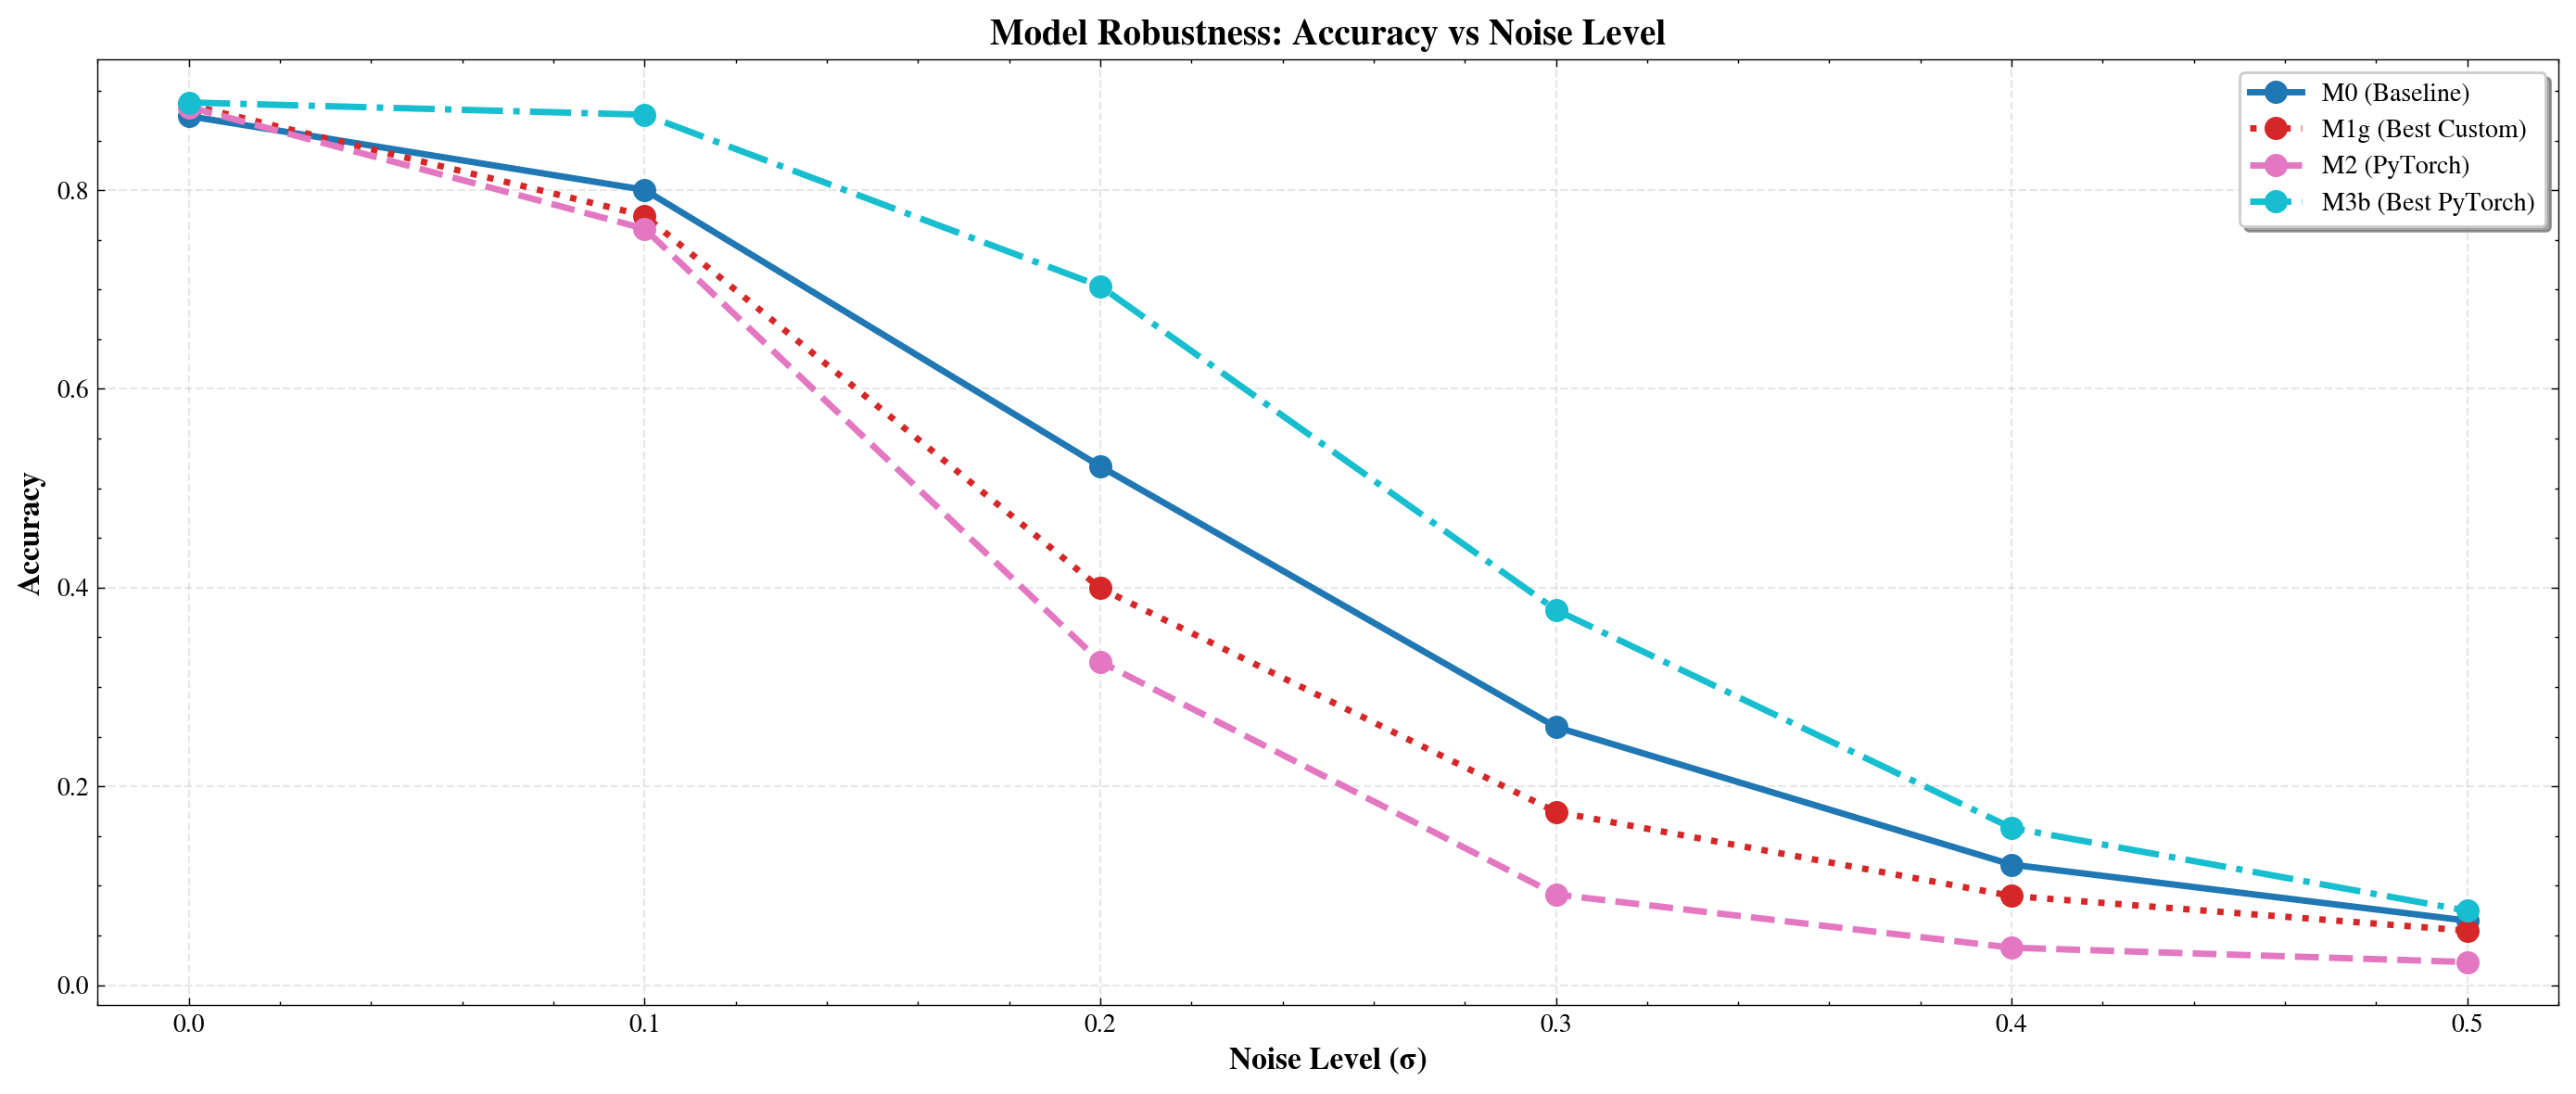

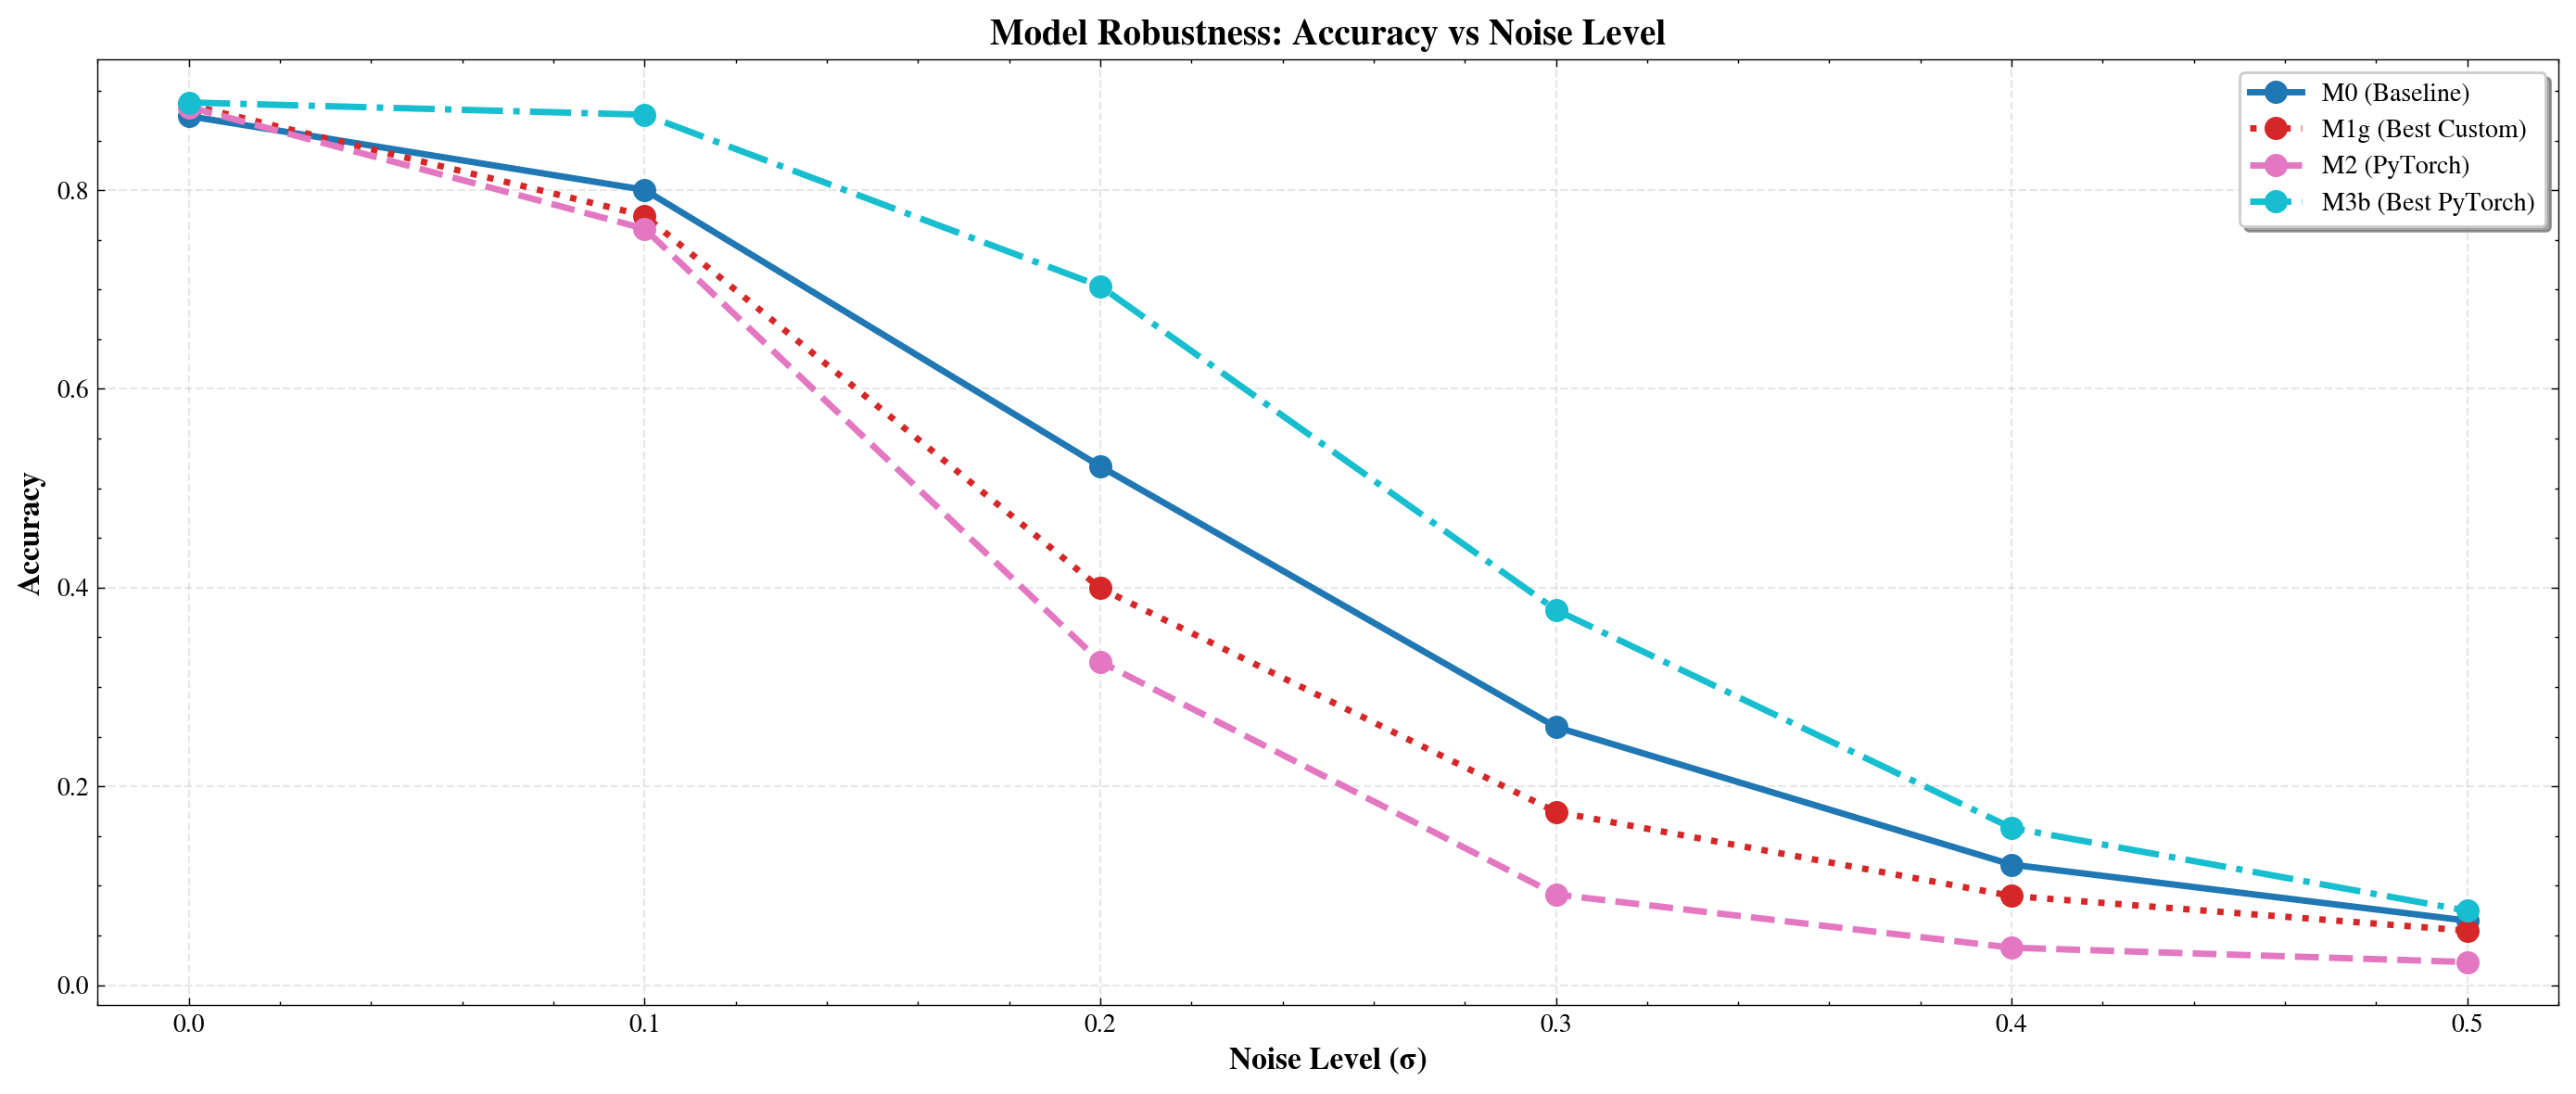

In [35]:
print("\n" + "=" * 80)
print("ANÁLISIS DE ROBUSTEZ: DEGRADACIÓN DE PERFORMANCE BAJO RUIDO")
print("=" * 80)


print("\n Accuracy para cada nivel de ruido:\n")
print(
    f"{'Model':<30} {'σ=0.0':<10} {'σ=0.1':<10} {'σ=0.2':<10} {'σ=0.3':<10} {'σ=0.4':<10} {'σ=0.5':<10}"
)
print("-" * 95)

for model_name, results in robustness_results.items():
    row = f"{model_name:<30}"
    for r in results:
        row += f" {r['accuracy']:<10.4f}"
    print(row)

print("\nDegradación porcentual de accuracy (% respecto a σ=0.0):\n")
print(
    f"{'Model':<30} {'σ=0.1':<10} {'σ=0.2':<10} {'σ=0.3':<10} {'σ=0.4':<10} {'σ=0.5':<10}"
)
print("-" * 85)

for model_name, results in robustness_results.items():
    acc_baseline = results[0]["accuracy"]

    row = f"{model_name:<30}"
    for i in range(1, len(results)):
        acc_noisy = results[i]["accuracy"]
        degradation = ((acc_baseline - acc_noisy) / acc_baseline) * 100
        row += f" {degradation:<10.2f}"
    print(row)

print("\nModelo más robusto:")
avg_high_noise = {}
for model_name, results in robustness_results.items():
    high_noise_acc = [r["accuracy"] for r in results if r["noise_level"] >= 0.3]
    avg_high_noise[model_name] = np.mean(high_noise_acc)

most_robust = max(avg_high_noise.items(), key=lambda x: x[1])
print(f"  {most_robust[0]}")
print(f"  Accuracy promedio con ruido alto (σ≥0.3): {most_robust[1]:.4f}")

print("=" * 80)

from neural_net.utils.visualization import plot_robustness_curves


plot_robustness_curves(
    robustness_results,
    save_path=project_root / "figures" / "robustness_analysis.png",
    figsize=(14, 6),
    style=str(project_root / "figs.mplstyle"),
)

<div style="font-family: Georgia, serif; font-size: 20px; line-height: 1.5;">

<style>
h1 { color: #8db2d7ff; font-weight: 700; }
h2 { color: #4a90e2; font-weight: 500; }
h3 { color: #6b8ea3; font-weight: 400; }
</style>


### Conclusiones del Análisis de Robustez

**Observaciones clave:**

1. **Degradación de performance:** Todos los modelos muestran degradación de accuracy
   a medida que aumenta el ruido. La curva de accuracy vs ruido permite comparar
   qué modelos mantienen mejor su performance bajo condiciones adversas.

2. **Modelos más robustos:** Los modelos con regularización (Dropout, L2, BatchNorm)
   tienden a ser más robustos ante ruido porque han aprendido features más generales
   y menos sensibles a perturbaciones pequeñas en los datos.

3. **Trade-off accuracy vs robustez:** El modelo con mejor accuracy en datos limpios
   NO necesariamente es el más robusto ante ruido. Esto es importante considerar
   según la aplicación.

4. **Importancia práctica:** En aplicaciones reales con datos imperfectos, la robustez
   puede ser tan importante como la accuracy en datos limpios.

<div style="font-family: Georgia, serif; font-size: 20px; line-height: 1.5;">

<style>
h1 { color: #8db2d7ff; font-weight: 700; }
h2 { color: #4a90e2; font-weight: 500; }
h3 { color: #6b8ea3; font-weight: 400; }
</style>

## 5. Predicciones para Conjunto de Competencia

Utilizamos el mejor modelo entrenado (M1g) para generar predicciones
sobre el conjunto de competencia `X_COMP.npy` que contiene 4,700 imágenes
nuevas sin etiquetas conocidas.

**Modelo seleccionado:** M1g (Best Custom Implementation)
- **Test Accuracy:** 88.58%
- **Test F1-Macro:** 85.73%
- **Arquitectura:** [400, 240, 120] (444,847 parámetros)
- **Optimizador:** Adam (lr=0.001)

In [36]:
import numpy as np
import cupy as cp
from pathlib import Path
from neural_net.models.mlp import MLP
from neural_net.layers import LayerType, Linear
from experiments.configs.configurations import M1g_CONFIG


X_comp_path = project_root / "data" / "X_COMP.npy"
X_comp = np.load(X_comp_path)
print(f"\n✓ Cargado X_COMP: {X_comp.shape[0]:,} muestras")
print(f"  Shape: {X_comp.shape}")
print(f"  Dtype: {X_comp.dtype}")
print(f"  Rango: [{X_comp.min()}, {X_comp.max()}]")

X_comp_normalized = X_comp.astype(np.float32) / 255.0
X_comp_flat = X_comp_normalized.reshape(X_comp.shape[0], -1)  
X_comp_transposed = X_comp_flat.T  
X_comp_gpu = cp.array(X_comp_transposed)

print(f"\nPreprocesamiento completado")
print(f"  Shape final: {X_comp_gpu.shape}")
print(f"  Rango: [{float(X_comp_gpu.min()):.4f}, {float(X_comp_gpu.max()):.4f}]")


✓ Cargado X_COMP: 4,700 muestras
  Shape: (4700, 28, 28)
  Dtype: uint8
  Rango: [0, 255]

Preprocesamiento completado
  Shape final: (784, 4700)
  Rango: [0.0000, 1.0000]


In [37]:
model_comp = MLP(
    input_dim=784,
    hidden_layers=M1g_CONFIG.model.hidden_layers,  
    output_dim=47,
    activation=LayerType.RELU,
    output_activation=LayerType.SOFTMAX,
    dropout_rate=None,  
)

print(f"\n Modelo M1g reconstruido")
print(f"  Capas: {len(model_comp.layers)}")
print(f"  Arquitectura: {M1g_CONFIG.model.hidden_layers}")

weights_path = project_root / "results" / "M1" / "M1g" / "m1g_weights.npz"
weights_data = np.load(weights_path)

linear_layers = [layer for layer in model_comp.layers if isinstance(layer, Linear)]
for layer_idx, layer in enumerate(linear_layers):
    W_key = f"layer_{layer_idx}_weights"
    b_key = f"layer_{layer_idx}_bias"
    layer.weights = cp.array(weights_data[W_key])
    layer.bias = cp.array(weights_data[b_key])

print(f"\n Pesos cargados desde entrenamiento previo")
print(f"  Capas lineales: {len(linear_layers)}")


 Modelo M1g reconstruido
  Capas: 8
  Arquitectura: [400, 240, 120]

 Pesos cargados desde entrenamiento previo
  Capas lineales: 4


In [38]:
print(f"\n Generando predicciones para {X_comp_gpu.shape[1]:,} muestras...")

probabilities_comp = model_comp.predict(X_comp_gpu) 

y_comp_pred = cp.argmax(probabilities_comp, axis=0)  
y_comp_pred_np = cp.asnumpy(y_comp_pred).astype(np.int32)

print(f"\n Predicciones generadas")
print(f"  Shape: {y_comp_pred_np.shape}")
print(f"  Dtype: {y_comp_pred_np.dtype}")
print(f"  Rango de clases: [{y_comp_pred_np.min()}, {y_comp_pred_np.max()}]")

unique_classes, counts = np.unique(y_comp_pred_np, return_counts=True)
print(f"\n Distribución de clases predichas:")
print(f"  Clases únicas: {len(unique_classes)}/47")
print(f"  Clase más frecuente: {unique_classes[counts.argmax()]} ({counts.max():,} muestras)")
print(f"  Clase menos frecuente: {unique_classes[counts.argmin()]} ({counts.min():,} muestras)")
print(f"  Promedio por clase: {y_comp_pred_np.shape[0]/47:.1f} muestras")


 Generando predicciones para 4,700 muestras...

 Predicciones generadas
  Shape: (4700,)
  Dtype: int32
  Rango de clases: [0, 46]

 Distribución de clases predichas:
  Clases únicas: 47/47
  Clase más frecuente: 9 (172 muestras)
  Clase menos frecuente: 21 (48 muestras)
  Promedio por clase: 100.0 muestras


In [39]:
output_path = project_root / "y_comp_pred.npy"
np.save(output_path, y_comp_pred_np)

print(f"\n✓ Predicciones guardadas en: {output_path.name}")
print(f"  Tamaño del archivo: {output_path.stat().st_size / 1024:.1f} KB")

y_loaded = np.load(output_path)
assert np.array_equal(y_loaded, y_comp_pred_np), "Error en verificación"
print(f"Verificación exitosa")

print("\n" + "="*70)
print("PREDICCIONES COMPLETADAS")
print("="*70)
print(f"\n Archivo generado: y_comp_pred.npy")
print(f"  Cantidad de predicciones: {len(y_comp_pred_np):,}")


✓ Predicciones guardadas en: y_comp_pred.npy
  Tamaño del archivo: 18.5 KB
Verificación exitosa

PREDICCIONES COMPLETADAS

 Archivo generado: y_comp_pred.npy
  Cantidad de predicciones: 4,700
